# Installs & Imports

In [ ]:
pip install matplotlib windrose

In [ ]:
# imports

from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import math
import sys, os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from windrose import WindroseAxes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools

In [ ]:
# mount drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data (Read & Clean)

In [ ]:
# read data

NHA_data_path = '/content/drive/My Drive/Capstone_P1_Data/NHADamData.csv'
df_NHA = pd.read_csv(NHA_data_path)

Boston_data_path = '/content/drive/My Drive/Capstone_P1_Data/Boston_Weather_Official.csv'
df_Boston = pd.read_csv(Boston_data_path)

Chicopee_data_path = '/content/drive/My Drive/Capstone_P1_Data/Chicopee_Weather_Official.csv'
df_Chicopee = pd.read_csv(Chicopee_data_path)

Sturbridge_data_path = '/content/drive/My Drive/Capstone_P1_Data/Sturbridge_Weather_Official.csv'
df_Sturbridge = pd.read_csv(Sturbridge_data_path)

# clean datasets

df_Boston['DateTime'] = pd.to_datetime(df_Boston[['Year','Month','Day','Hour','Minute']])
df_Boston.set_index('DateTime', inplace=True)
df_Boston.drop(columns=['Year','Month','Day','Hour','Minute'], inplace=True)
df_Boston = df_Boston.resample('W').mean()
df_Boston['City'] = 'Boston'

df_Chicopee['DateTime'] = pd.to_datetime(df_Chicopee[['Year','Month','Day','Hour','Minute']])
df_Chicopee.set_index('DateTime', inplace=True)
df_Chicopee.drop(columns=['Year','Month','Day','Hour','Minute'], inplace=True)
df_Chicopee = df_Chicopee.resample('W').mean()
df_Chicopee['City'] = 'Chicopee'

df_Sturbridge['DateTime'] = pd.to_datetime(df_Sturbridge[['Year','Month','Day','Hour','Minute']])
df_Sturbridge.set_index('DateTime', inplace=True)
df_Sturbridge.drop(columns=['Year','Month','Day','Hour','Minute'], inplace=True)
df_Sturbridge = df_Sturbridge.resample('W').mean()
df_Sturbridge['City'] = 'Sturbridge'

# merge datasets for EDA

df_All = pd.concat([df_Boston, df_Chicopee, df_Sturbridge])

df_All['Wk_End_Dt'] = df_All.index

df_All.reset_index(inplace=True)

In [ ]:
# Nationa Hydro Power data

display(df_NHA.head())

,Name,Owner,Hydro?,Type,Capacity,City
0,Aqueduct Transfere Hydro Station,Massachusetts Water Resource Authority,Y,Conventional Hydro,0.750,Southborough
1,Ashley Reservoir Hydro Station,"City of Pittsfield, MA",Y,Conventional Hydro,0.225,Pittsfield
2,Assabet,"Acton Hydro Company, Inc.",Y,Conventional Hydro,0.178,Acton
3,Beebe Holbrook,Holyoke Water Power Company,Y,Conventional Hydro,0.516,Holbrook
4,Boatlock,City of Holyoke Gas and Electric Dept.,Y,Conventional Hydro,3.100,Holyoke


In [ ]:
# Climatological data

display(df_All.head())

,DateTime,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Wind Direction,Wind Speed,City,Wk_End_Dt
0,2018-01-07,-11.418452,-13.326786,86.511905,86.302857,1012.994048,259.982143,1.713095,Boston,2018-01-07
1,2018-01-14,-0.136905,-2.033929,80.416667,87.665357,1018.041667,243.684524,1.344643,Boston,2018-01-14
2,2018-01-21,-2.423214,-4.538690,76.511905,85.869762,1018.690476,216.511905,1.105952,Boston,2018-01-21
3,2018-01-28,0.877381,-1.845238,70.625000,83.411012,1018.720238,232.500000,1.312500,Boston,2018-01-28
4,2018-02-04,-2.611310,-5.610714,80.940476,80.613036,1015.577381,218.642857,1.611905,Boston,2018-02-04


# EDA

## Weather Visuals

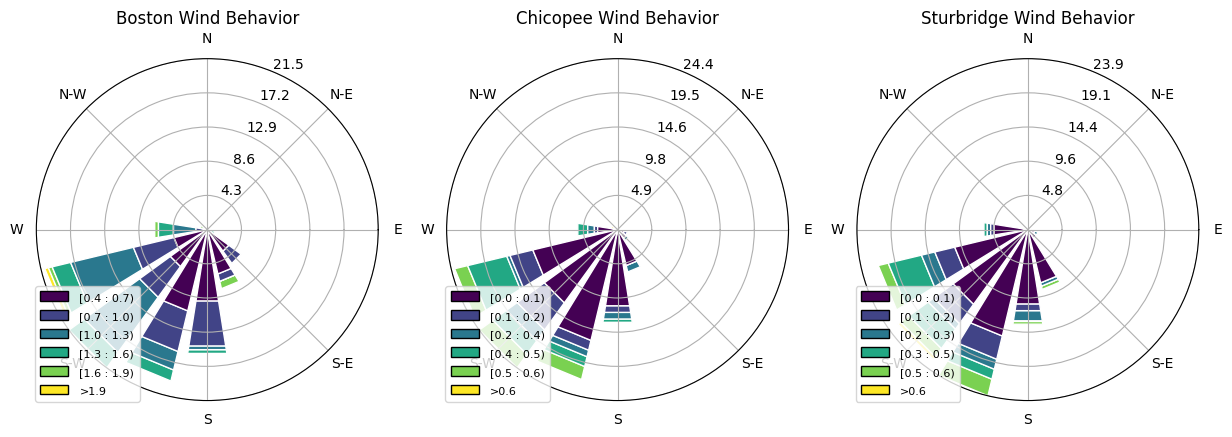

In [ ]:
# plot windrose for each city

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection='windrose'), figsize=(15, 5))

cities = ['Boston', 'Chicopee', 'Sturbridge']

for i, city in enumerate(cities):
    ax = axes[i]
    df_city = df_All[df_All['City'] == city]
    ax.bar(df_city['Wind Direction'], df_city['Wind Speed'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    ax.set_title(f'{city} Wind Behavior')

plt.show()

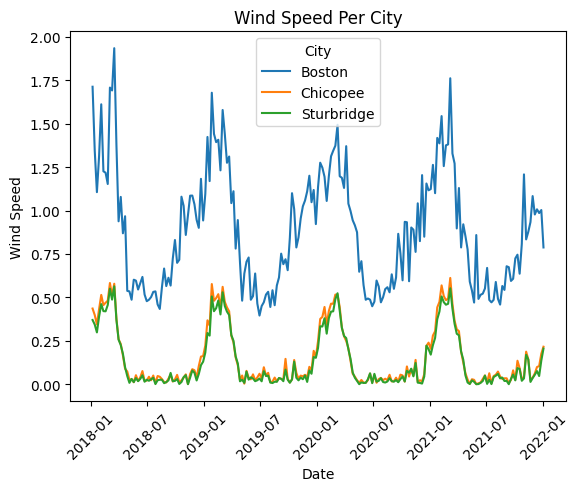

In [ ]:
# plot wind speed trends

sns.lineplot(x=df_All.Wk_End_Dt, y=df_All['Wind Speed'], hue=df_All['City'])
plt.title('Wind Speed Per City')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

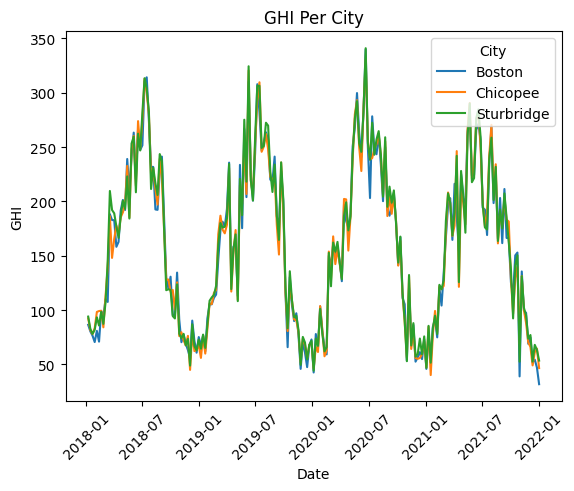

In [ ]:
# plot GHI trends

sns.lineplot(x=df_All.Wk_End_Dt, y=df_All['GHI'], hue=df_All['City'])
plt.title('GHI Per City')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

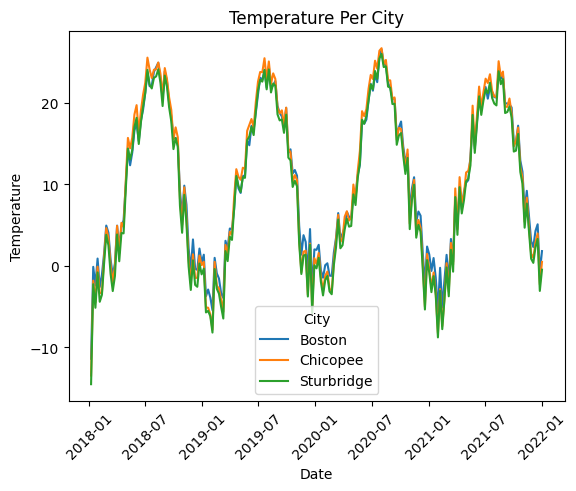

In [ ]:
# plot temperature trends

sns.lineplot(x=df_All.Wk_End_Dt, y=df_All['Temperature'], hue=df_All['City'])
plt.title('Temperature Per City')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

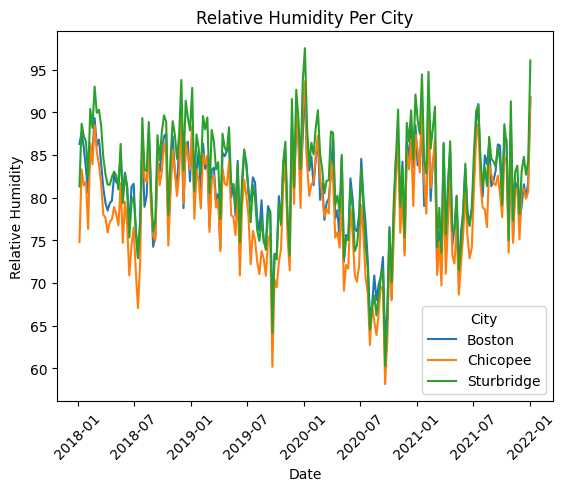

In [ ]:
# plot relative humidity trends

sns.lineplot(x=df_All.Wk_End_Dt, y=df_All['Relative Humidity'], hue=df_All['City'])
plt.title('Relative Humidity Per City')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

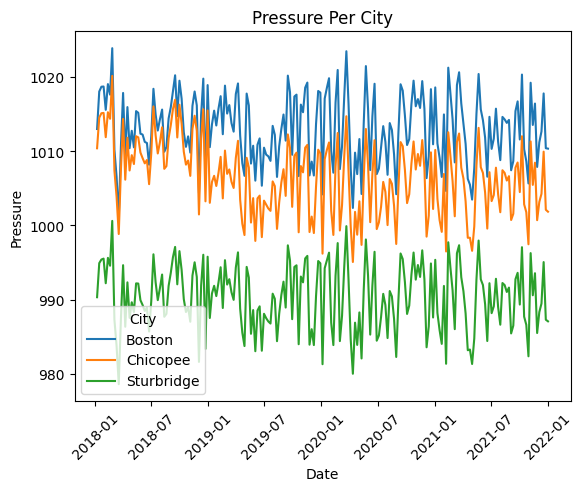

In [ ]:
# plot pressure trends

sns.lineplot(x=df_All.Wk_End_Dt, y=df_All['Pressure'], hue=df_All['City'])
plt.title('Pressure Per City')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

## Dam Visuals

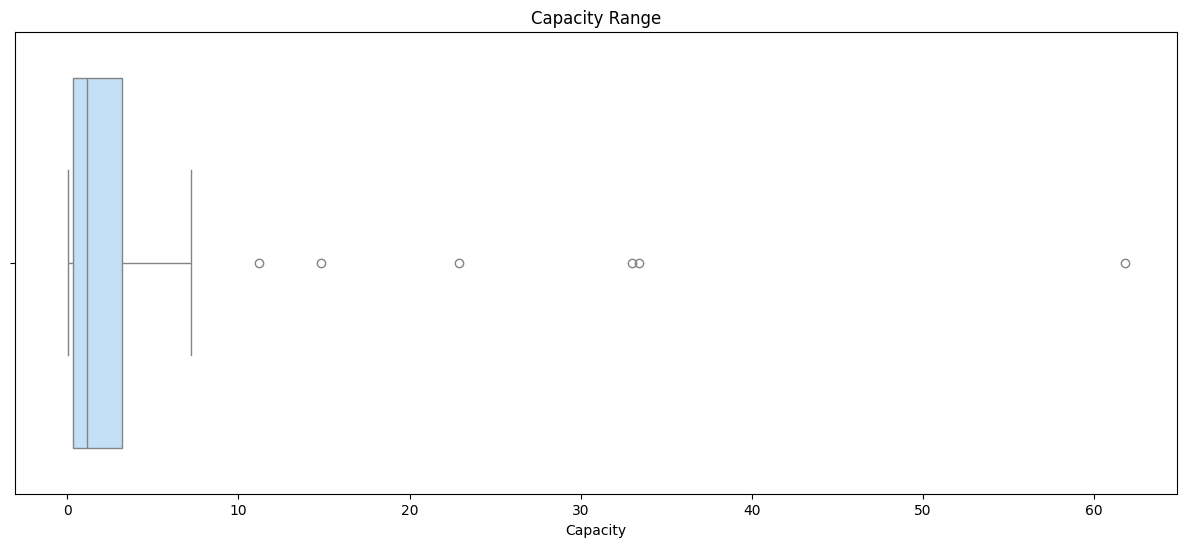

In [ ]:
# plot capacity range

plt.figure(figsize=(15, 6))
sns.boxplot(x='Capacity', data=df_NHA, color="#BAE1FF")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=10))
plt.title('Capacity Range')
plt.show()

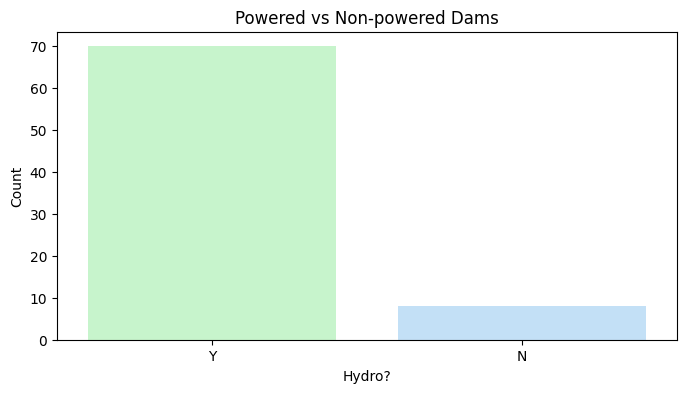

In [ ]:
# plot Powered vs Non-Powered Dams

custom_palette = ["#BFFCC6", "#BAE1FF"]

plt.figure(figsize=(8, 4))
sns.countplot(x='Hydro?', data=df_NHA, hue='Hydro?', palette=custom_palette)

plt.xlabel('Hydro?')
plt.ylabel('Count')
plt.title('Powered vs Non-powered Dams')
plt.show()

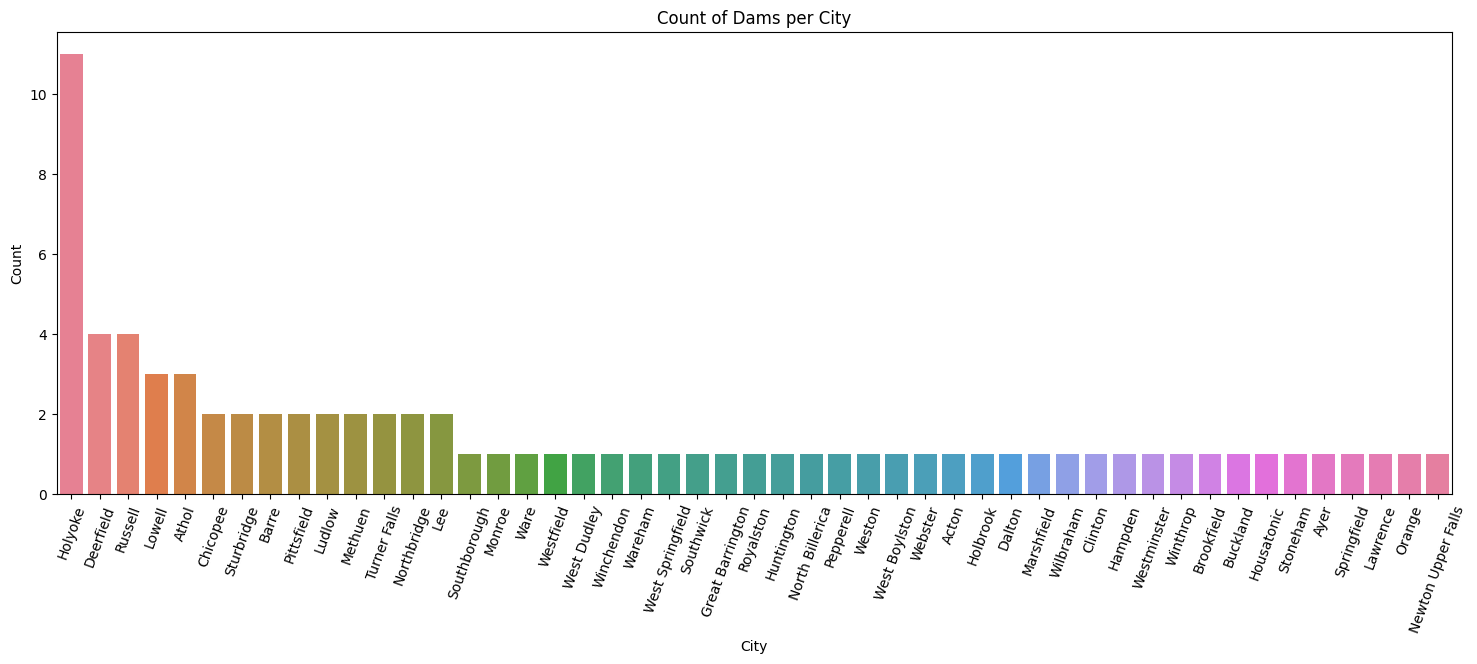

In [ ]:
# Plot dams per city

dam_counts = df_NHA['City'].value_counts()

dam_counts_df = dam_counts.reset_index()
dam_counts_df.columns = ['City', 'Count']

palette = sns.color_palette("husl", len(dam_counts_df))

plt.figure(figsize=(18, 6))
sns.barplot(x='City', y='Count', data=dam_counts_df, hue='City', palette=palette)
plt.title('Count of Dams per City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=70)
plt.show()

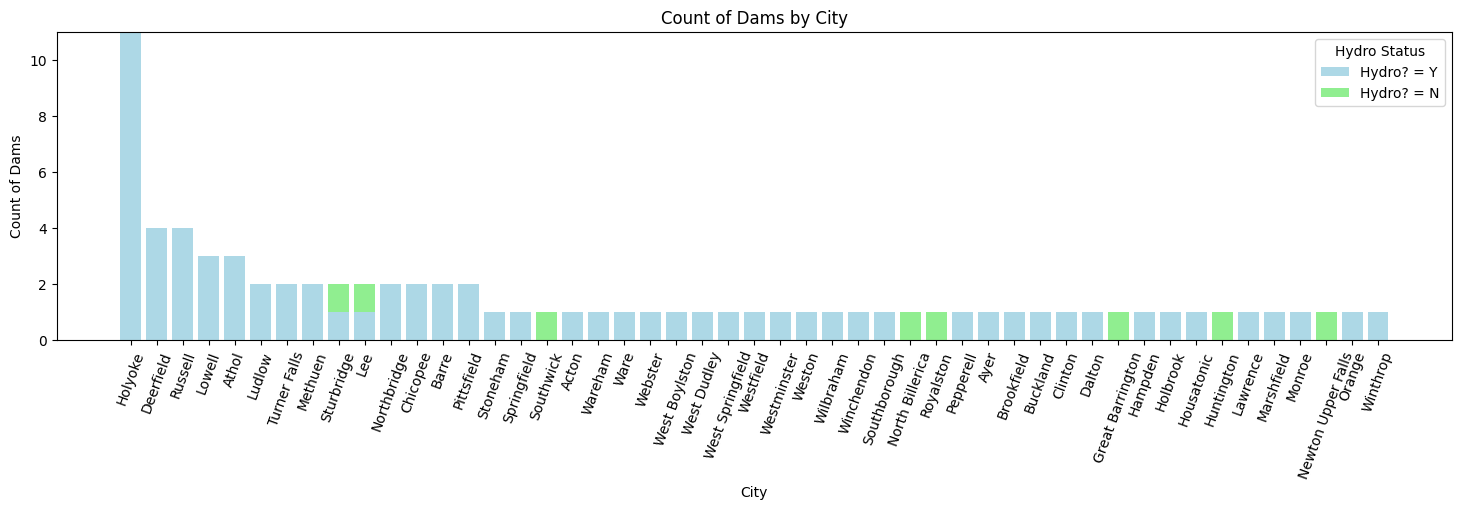

In [ ]:
count_df = df_NHA.groupby(['City', 'Hydro?']).size().unstack(fill_value=0)

count_df['Total'] = count_df.sum(axis=1)

count_df = count_df.sort_values(by='Total', ascending=False)

count_df = count_df.drop(columns='Total')

fig, ax = plt.subplots(figsize=(18, 4))

colors = {'Y': 'lightblue', 'N': 'lightgreen'}

bottom = [0] * len(count_df)
for hydro_status in ['Y', 'N']:
    values = count_df[hydro_status].values
    ax.bar(count_df.index, values, bottom=bottom, color=colors[hydro_status], label=f'Hydro? = {hydro_status}')
    bottom = [i+j for i, j in zip(bottom, values)]

ax.set_xlabel('City')
ax.set_ylabel('Count of Dams')
ax.set_title('Count of Dams by City')
ax.legend(title='Hydro Status')

plt.xticks(rotation=70)
plt.show()

# Train Models

## Defined Models

In [ ]:
# define SARIMA model

def fit_sarima_model(train, test, p, d, q, P, D, Q, s):
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit(disp=False)
    test_forecast = results.get_forecast(steps=len(test)).predicted_mean
    mse = mean_squared_error(test, test_forecast)
    return mse, results

## Wind Speed

In [ ]:
# find ADF statistics and p values

result = adfuller(df_Boston["Wind Speed"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

df_diff = df_Boston["Wind Speed"].diff().dropna()

result_diff = adfuller(df_diff)
print(f'ADF Statistic (after differencing): {result_diff[0]}')
print(f'p-value (after differencing): {result_diff[1]}')

ADF Statistic: -4.487700341937076
p-value: 0.00020695130764544027
ADF Statistic (after differencing): -4.898625520398223
p-value (after differencing): 3.508983646039025e-05


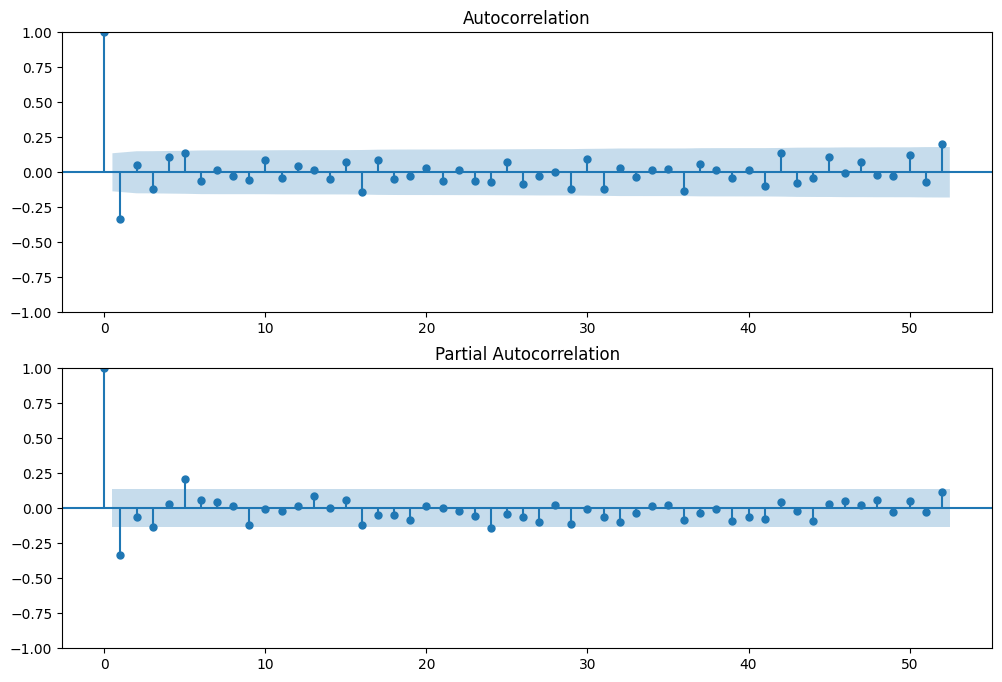

In [ ]:
# plot acf and pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=52, ax=ax[0])
plot_pacf(df_diff, lags=52, ax=ax[1])
plt.show()

SARIMA(0,0,0)x(0,0,0,52) - MSE: 0.8618433863325204


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,1,52) - MSE: 0.2525954923126228


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,2,52) - MSE: 0.18425655720079623
SARIMA(0,0,0)x(1,0,0,52) - MSE: 0.030975903965610313


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,1,52) - MSE: 0.026971675918746264


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,2,52) - MSE: 0.03907332015290052
SARIMA(0,0,0)x(2,0,0,52) - MSE: 0.02711327178818042


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(2,0,1,52) - MSE: 0.028721197332837338


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(2,0,2,52) - MSE: 0.03798356405371933
SARIMA(0,0,1)x(0,0,0,52) - MSE: 0.8597528491214389


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(0,0,1,52) - MSE: 0.2677129630356537


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(0,0,2,52) - MSE: 0.21376456394562743
SARIMA(0,0,1)x(1,0,0,52) - MSE: 0.031633172878863976


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(1,0,1,52) - MSE: 0.026037856331251937


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,1)x(1,0,2,52) - MSE: 0.026915024473651638
SARIMA(0,0,1)x(2,0,0,52) - MSE: 0.02659110394977628


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,1)x(2,0,1,52) - MSE: 0.026115797501638963


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,1)x(2,0,2,52) - MSE: 0.02648810078182561
SARIMA(0,0,2)x(0,0,0,52) - MSE: 0.8206657910922915


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(0,0,1,52) - MSE: 0.2408624868978429


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(0,0,2,52) - MSE: 0.20425198415538123
SARIMA(0,0,2)x(1,0,0,52) - MSE: 0.03540861349484325


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(1,0,1,52) - MSE: 0.030131521963415772


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(1,0,2,52) - MSE: 0.03232959373424135
SARIMA(0,0,2)x(2,0,0,52) - MSE: 0.03088047220935121


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(2,0,1,52) - MSE: 0.03050861434807807


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(2,0,2,52) - MSE: 0.029537963162764424
SARIMA(1,0,0)x(0,0,0,52) - MSE: 0.08443524263626738


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,1,52) - MSE: 0.07266311145480644


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,2,52) - MSE: 0.06755103605186653
SARIMA(1,0,0)x(1,0,0,52) - MSE: 0.05692406376703897


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(1,0,1,52) - MSE: 0.06719183475095963


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(1,0,2,52) - MSE: 0.06285810570052057


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,0,52) - MSE: 0.06430647807114034


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,1,52) - MSE: 0.07975860953730388


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,2,52) - MSE: 0.056963403548931306
SARIMA(1,0,1)x(0,0,0,52) - MSE: 0.10411117547556703


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,1,52) - MSE: 0.05902370940980104


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,2,52) - MSE: 0.057543611433820724
SARIMA(1,0,1)x(1,0,0,52) - MSE: 0.05229709157252793


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(1,0,1,52) - MSE: 0.056071203829263686


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(1,0,2,52) - MSE: 0.04320644306432866
SARIMA(1,0,1)x(2,0,0,52) - MSE: 0.05378602113355628


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(2,0,1,52) - MSE: 0.04825968763213187


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(2,0,2,52) - MSE: 0.03749435483700573
SARIMA(1,0,2)x(0,0,0,52) - MSE: 0.10412188425633957


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,1,52) - MSE: 0.058349672410961353


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,2,52) - MSE: 0.057770366251512856
SARIMA(1,0,2)x(1,0,0,52) - MSE: 0.0474113022702625


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(1,0,1,52) - MSE: 0.05168928649488406


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(1,0,2,52) - MSE: 0.04700801445640899
SARIMA(1,0,2)x(2,0,0,52) - MSE: 0.05212258175061282


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,1,52) - MSE: 0.0493552982646855


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,2,52) - MSE: 0.036003437814572124
SARIMA(2,0,0)x(0,0,0,52) - MSE: 0.09544315570469739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,1,52) - MSE: 0.05549961001863544


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,2,52) - MSE: 0.05404664996508249
SARIMA(2,0,0)x(1,0,0,52) - MSE: 0.04699251064077556


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(1,0,1,52) - MSE: 0.053470434759280275


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(1,0,2,52) - MSE: 0.04998481822161561
SARIMA(2,0,0)x(2,0,0,52) - MSE: 0.0554986405747491


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(2,0,1,52) - MSE: 0.05098155614293591


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(2,0,2,52) - MSE: 0.039807332404110496
SARIMA(2,0,1)x(0,0,0,52) - MSE: 0.10411851347146295


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,1,52) - MSE: 0.05838488235785306


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,2,52) - MSE: 0.05780058831102269
SARIMA(2,0,1)x(1,0,0,52) - MSE: 0.04784011984011393


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(1,0,1,52) - MSE: 0.052013558581683


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(1,0,2,52) - MSE: 0.04629074614986911
SARIMA(2,0,1)x(2,0,0,52) - MSE: 0.05105506533973084


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(2,0,1,52) - MSE: 0.04819833184242259


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(2,0,2,52) - MSE: 0.036226200206433086


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,2)x(0,0,0,52) - MSE: 0.10183790965401562


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(0,0,1,52) - MSE: 0.05755315585248454


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(0,0,2,52) - MSE: 0.05386767187896628


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,0,52) - MSE: 0.05171540430521328


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,1,52) - MSE: 0.05299315543704001


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,2,52) - MSE: 0.0547604460522562


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,0,52) - MSE: 0.05249377977371496


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,1,52) - MSE: 0.05646124503228514


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,2,52) - MSE: 0.04415123065157337
Best model: SARIMA(0, 0, 1, 1, 0, 1, 52) - MSE: 0.026037856331251937


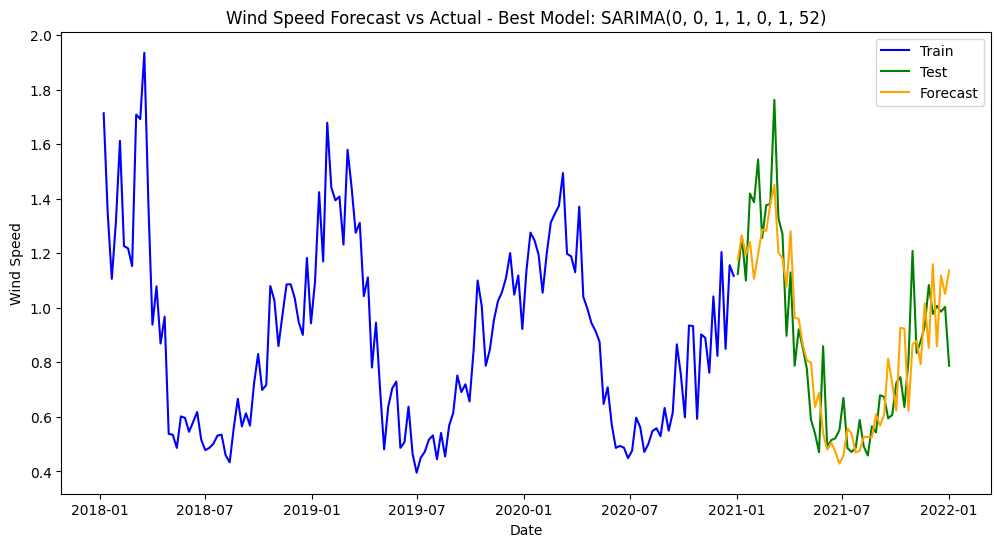

In [ ]:
# search for best SARIMA parameters

train_size = int(len(df_Boston[["Wind Speed"]]) * 0.75)
train, test = df_Boston[["Wind Speed"]][:train_size], df_Boston[["Wind Speed"]][train_size:]

p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 1)
Q_values = range(0, 3)
s_values = [52]

best_mse = float('inf')
best_params = None
best_model = None

for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    try:
        mse, results = fit_sarima_model(train, test, p, d, q, P, D, Q, s)
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q, P, D, Q, s)
            best_model = results
        print(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - MSE: {mse}')
    except Exception as e:
        print(f'Error fitting ARIMA({p},{d},{q})x({P},{D},{Q},{s}): {e}')

print(f'Best model: SARIMA{best_params} - MSE: {best_mse}')

test_forecast = best_model.get_forecast(steps=len(test)).predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, test_forecast, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.title(f'Wind Speed Forecast vs Actual - Best Model: SARIMA{best_params}')
plt.legend()
plt.show()

## GHI

In [ ]:
# find ADF statistics and p values

result = adfuller(df_Boston["GHI"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

df_diff = df_Boston["GHI"].diff().dropna()

result_diff = adfuller(df_diff)
print(f'ADF Statistic (after differencing): {result_diff[0]}')
print(f'p-value (after differencing): {result_diff[1]}')

ADF Statistic: -5.6350639911906395
p-value: 1.0677346378110503e-06
ADF Statistic (after differencing): -3.9796661872996175
p-value (after differencing): 0.001520808709777544


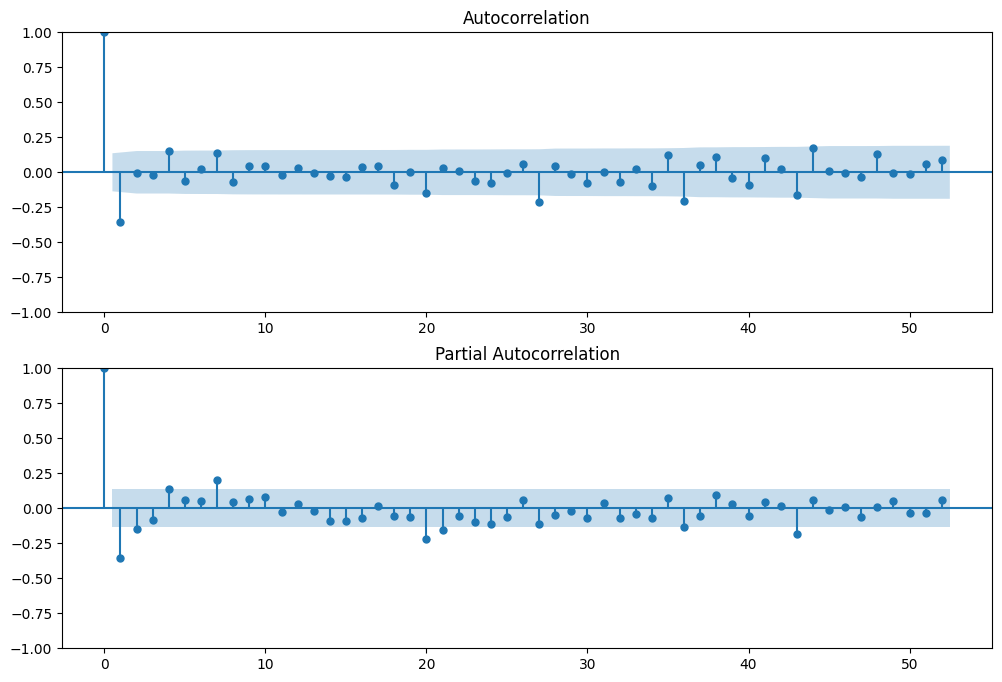

In [ ]:
# plot acf and pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=52, ax=ax[0])
plot_pacf(df_diff, lags=52, ax=ax[1])
plt.show()

SARIMA(0,0,0)x(0,0,0,52) - MSE: 29340.937452429083


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,1,52) - MSE: 7771.324041212541


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,2,52) - MSE: 5860.5275660649495
SARIMA(0,0,0)x(1,0,0,52) - MSE: 1185.1252443724447


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,1,52) - MSE: 1066.7887982174238


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,2,52) - MSE: 1126.988842925517


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(0,0,0)x(2,0,0,52) - MSE: 1081.2429905648653


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(2,0,1,52) - MSE: 1127.8016893854972


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Error fitting ARIMA(0,0,0)x(2,0,2,52): LU decomposition error.
SARIMA(0,0,1)x(0,0,0,52) - MSE: 29322.947513328956


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(0,0,1,52) - MSE: 7762.125476415534


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,1)x(0,0,2,52) - MSE: 7389.507572626335
SARIMA(0,0,1)x(1,0,0,52) - MSE: 1140.8955008709872


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,1)x(1,0,1,52) - MSE: 1048.66221674008


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(1,0,2,52) - MSE: 7723.804559835184


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(0,0,1)x(2,0,0,52) - MSE: 1119.1806201775971


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(2,0,1,52) - MSE: 1244.4491641615102


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(2,0,2,52) - MSE: 1182.8636007495961
SARIMA(0,0,2)x(0,0,0,52) - MSE: 29224.667343700025


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(0,0,1,52) - MSE: 12271.649955600391


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(0,0,2,52) - MSE: 7974.416471175465
SARIMA(0,0,2)x(1,0,0,52) - MSE: 6003.166422096083


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(1,0,1,52) - MSE: 29198.01283928117


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(1,0,2,52) - MSE: 7780.862449136492


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(0,0,2)x(2,0,0,52) - MSE: 1175.6432642094271


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(2,0,1,52) - MSE: 1294.1062248908654


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(2,0,2,52) - MSE: 4203.700250599416
SARIMA(1,0,0)x(0,0,0,52) - MSE: 18952.440835489426


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,1,52) - MSE: 17434.261206129093


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,2,52) - MSE: 13787.529447132321
SARIMA(1,0,0)x(1,0,0,52) - MSE: 17254.29203080925


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(1,0,1,52) - MSE: 12646.727305191675


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(1,0,2,52) - MSE: 9762.992702707705


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(1,0,0)x(2,0,0,52) - MSE: 13307.172230807522


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,1,52) - MSE: 9991.612842562577


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,2,52) - MSE: 11041.350290520022
SARIMA(1,0,1)x(0,0,0,52) - MSE: 16194.304937304954


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,1,52) - MSE: 12804.678968535405


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,2,52) - MSE: 9042.161951703463
SARIMA(1,0,1)x(1,0,0,52) - MSE: 11978.377571212724


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(1,0,1,52) - MSE: 6406.657275217686


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(1,0,2,52) - MSE: 6083.016414812753


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(1,0,1)x(2,0,0,52) - MSE: 8144.012861214467


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(2,0,1,52) - MSE: 5867.535855185609


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(2,0,2,52) - MSE: 6175.525750406472
SARIMA(1,0,2)x(0,0,0,52) - MSE: 16259.16576486715


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,1,52) - MSE: 12880.148717566308


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,2,52) - MSE: 9044.312623237178


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(1,0,0,52) - MSE: 10986.833630576808


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(1,0,1,52) - MSE: 6440.480205464215


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(1,0,2,52) - MSE: 5692.336502403734


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(1,0,2)x(2,0,0,52) - MSE: 8144.187706223858


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,1,52) - MSE: 5832.338315646679


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,2,52) - MSE: 6072.15788023188
SARIMA(2,0,0)x(0,0,0,52) - MSE: 16917.936789128853


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,1,52) - MSE: 14732.96235136205


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,2,52) - MSE: 11189.185298085238
SARIMA(2,0,0)x(1,0,0,52) - MSE: 14343.602610552522


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(1,0,1,52) - MSE: 9257.088995588607


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(1,0,2,52) - MSE: 7730.747798659643


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(2,0,0)x(2,0,0,52) - MSE: 10555.984521583865


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(2,0,1,52) - MSE: 7778.793463365895


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(2,0,2,52) - MSE: 8534.502934220349
SARIMA(2,0,1)x(0,0,0,52) - MSE: 16235.414665894456


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,1,52) - MSE: 12855.171421449388


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,2,52) - MSE: 9043.695798248922
SARIMA(2,0,1)x(1,0,0,52) - MSE: 12035.07701447149


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(1,0,1,52) - MSE: 6444.008979176358


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(1,0,2,52) - MSE: 6625.109351420154


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(2,0,1)x(2,0,0,52) - MSE: 8144.30224377444


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(2,0,1,52) - MSE: 6196.790669702985


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(2,0,2,52) - MSE: 6508.736958398657


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,2)x(0,0,0,52) - MSE: 16209.715763022796


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,2)x(0,0,1,52) - MSE: 12860.201059015442


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,2)x(0,0,2,52) - MSE: 8998.248666817819


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,2)x(1,0,0,52) - MSE: 11782.771309266842


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,2)x(1,0,1,52) - MSE: 12971.783575742846


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,2,52) - MSE: 5832.81702097656


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(2,0,2)x(2,0,0,52) - MSE: 8195.248226251175


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,1,52) - MSE: 9072.664382195051


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,2,52) - MSE: 6290.611753699149
Best model: SARIMA(0, 0, 1, 1, 0, 1, 52) - MSE: 1048.66221674008


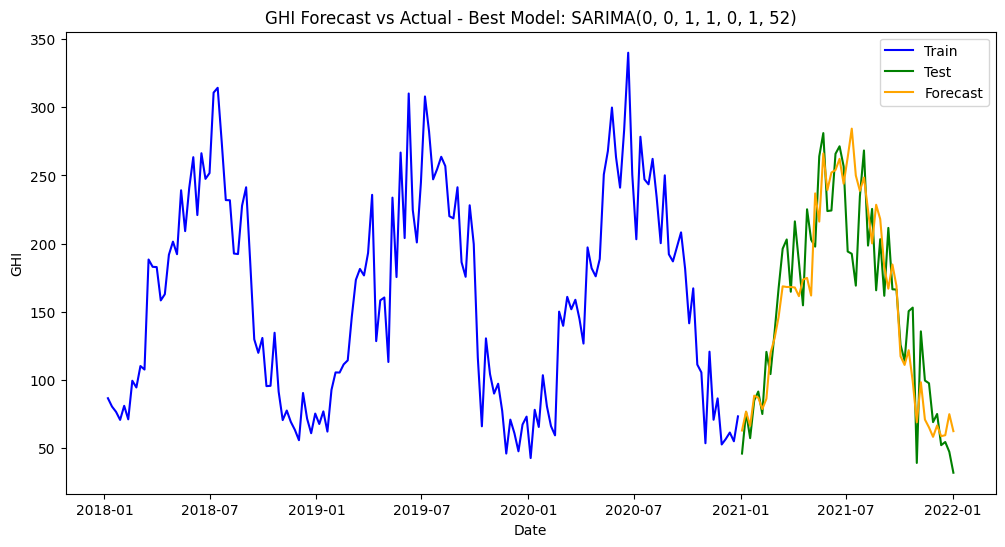

In [ ]:
# search for best SARIMA parameters

train_size = int(len(df_Boston[["GHI"]]) * 0.75)
train, test = df_Boston[["GHI"]][:train_size], df_Boston[["GHI"]][train_size:]

p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 1)
Q_values = range(0, 3)
s_values = [52]

best_mse = float('inf')
best_params = None
best_model = None

for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    try:
        mse, results = fit_sarima_model(train, test, p, d, q, P, D, Q, s)
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q, P, D, Q, s)
            best_model = results
        print(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - MSE: {mse}')
    except Exception as e:
        print(f'Error fitting ARIMA({p},{d},{q})x({P},{D},{Q},{s}): {e}')

print(f'Best model: SARIMA{best_params} - MSE: {best_mse}')

test_forecast = best_model.get_forecast(steps=len(test)).predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, test_forecast, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('GHI')
plt.title(f'GHI Forecast vs Actual - Best Model: SARIMA{best_params}')
plt.legend()
plt.show()

## Temperature

In [ ]:
# find ADF statistics and p values

result = adfuller(df_Boston["Temperature"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

df_diff = df_Boston["Temperature"].diff().dropna()

result_diff = adfuller(df_diff)
print(f'ADF Statistic (after differencing): {result_diff[0]}')
print(f'p-value (after differencing): {result_diff[1]}')

ADF Statistic: -7.534056093405523
p-value: 3.5163864620725656e-11
ADF Statistic (after differencing): -2.963814486983968
p-value (after differencing): 0.038414654296744115


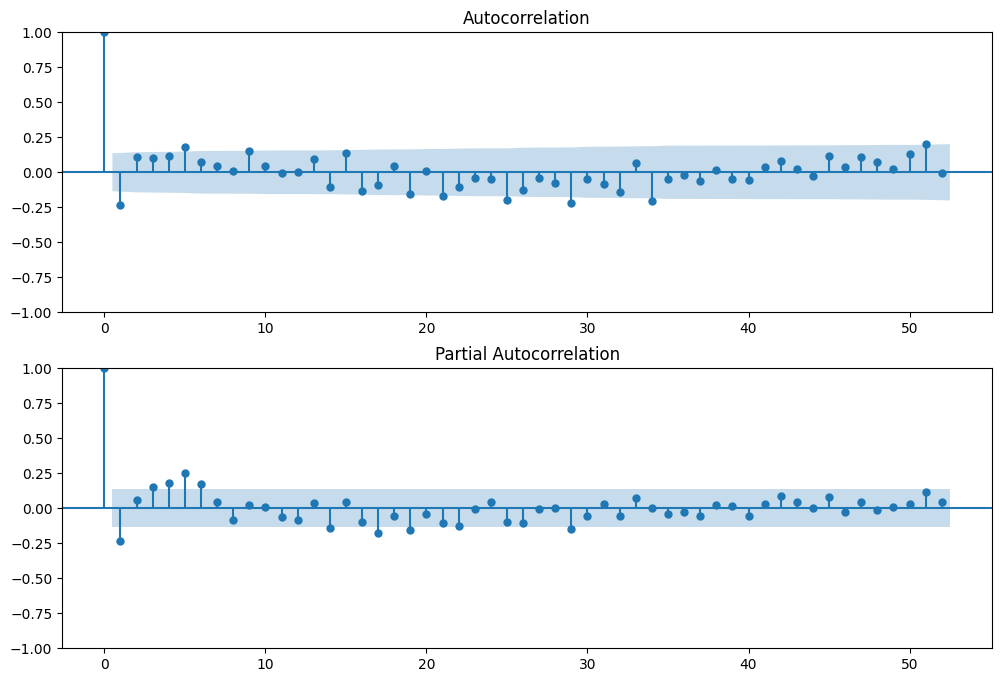

In [ ]:
# plot acf and pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=52, ax=ax[0])
plot_pacf(df_diff, lags=52, ax=ax[1])
plt.show()

SARIMA(0,0,0)x(0,0,0,52) - MSE: 189.08960050298415


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,1,52) - MSE: 51.93879774067342


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,2,52) - MSE: 45.04031518707997
SARIMA(0,0,0)x(1,0,0,52) - MSE: 8.76883193440929


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,1,52) - MSE: 6.072742479354768


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,2,52) - MSE: 6.949734476170189


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(0,0,0)x(2,0,0,52) - MSE: 6.1396520203487315


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(2,0,1,52) - MSE: 7.158355116881744


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(2,0,2,52) - MSE: 6.184204748433115
SARIMA(0,0,1)x(0,0,0,52) - MSE: 189.10166064428577


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(0,0,1,52) - MSE: 52.00079920394116


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(0,0,2,52) - MSE: 55.83655029773587
SARIMA(0,0,1)x(1,0,0,52) - MSE: 9.056817386195988


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(1,0,1,52) - MSE: 5.9651577933441065


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(1,0,2,52) - MSE: 8.097855611317717


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(0,0,1)x(2,0,0,52) - MSE: 6.067414610527604


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(2,0,1,52) - MSE: 6.969901031187991


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(2,0,2,52) - MSE: 6.038487240556348
SARIMA(0,0,2)x(0,0,0,52) - MSE: 189.2156773750314


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(0,0,1,52) - MSE: 66.87790324798479


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(0,0,2,52) - MSE: 60.30722616833522
SARIMA(0,0,2)x(1,0,0,52) - MSE: 10.744689149783124


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(1,0,1,52) - MSE: 6.516438908232747


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(1,0,2,52) - MSE: 9.416814125530172


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(0,0,2)x(2,0,0,52) - MSE: 6.826779899210325


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(2,0,1,52) - MSE: 9.56506199707951


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(2,0,2,52) - MSE: 10.033362699136486
SARIMA(1,0,0)x(0,0,0,52) - MSE: 168.1160959518728


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,1,52) - MSE: 165.76433196171698


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,2,52) - MSE: 158.47930370112758
SARIMA(1,0,0)x(1,0,0,52) - MSE: 165.69386441151815


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(1,0,1,52) - MSE: 165.67267789868362


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(1,0,2,52) - MSE: 158.47137101475315


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(1,0,0)x(2,0,0,52) - MSE: 158.42824664719194


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(2,0,1,52) - MSE: 158.4801233614086


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(2,0,2,52) - MSE: 158.46005822973797
SARIMA(1,0,1)x(0,0,0,52) - MSE: 169.87364169606724


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,1,52) - MSE: 150.42931131316476


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,2,52) - MSE: 132.29345637026378
SARIMA(1,0,1)x(1,0,0,52) - MSE: 147.7914415142183


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(1,0,1,52) - MSE: 119.26815064130422


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(1,0,2,52) - MSE: 131.8405623520136


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(1,0,1)x(2,0,0,52) - MSE: 129.40885530244972


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(2,0,1,52) - MSE: 130.5628044602522


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(2,0,2,52) - MSE: 182.25125249527528
SARIMA(1,0,2)x(0,0,0,52) - MSE: 173.60063852425105


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,1,52) - MSE: 160.35752796279553


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,2,52) - MSE: 153.60277543625716
SARIMA(1,0,2)x(1,0,0,52) - MSE: 159.4637541731365


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(1,0,1,52) - MSE: 143.41623593185676


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(1,0,2,52) - MSE: 144.1473978210936


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(1,0,2)x(2,0,0,52) - MSE: 152.604830342252


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,1,52) - MSE: 144.036708009816


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,2,52) - MSE: 138.53742548569775
SARIMA(2,0,0)x(0,0,0,52) - MSE: 170.95503209761497


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,1,52) - MSE: 152.1194912956948


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,2,52) - MSE: 138.4685718980861
SARIMA(2,0,0)x(1,0,0,52) - MSE: 149.98101280829223


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(1,0,1,52) - MSE: 125.24825906506726


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(1,0,2,52) - MSE: 137.5377941931168


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(2,0,0)x(2,0,0,52) - MSE: 136.0947737156175


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(2,0,1,52) - MSE: 136.43715157518548


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(2,0,2,52) - MSE: 121.80350582107489
SARIMA(2,0,1)x(0,0,0,52) - MSE: 171.075465369516


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,1,52) - MSE: 154.08707849826237


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,2,52) - MSE: 141.1623830551905
SARIMA(2,0,1)x(1,0,0,52) - MSE: 152.2957126112502


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(1,0,1,52) - MSE: 128.62764234938578


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(1,0,2,52) - MSE: 129.15253557081337


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMA(2,0,1)x(2,0,0,52) - MSE: 139.13299291234387


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(2,0,1,52) - MSE: 129.15794359894795


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(2,0,2,52) - MSE: 139.34371510739635


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,2)x(0,0,0,52) - MSE: 285.40753096739496


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(0,0,1,52) - MSE: 150.2720573833781


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(0,0,2,52) - MSE: 127.40699322542586


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,2)x(1,0,0,52) - MSE: 333.6905999868138


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,1,52) - MSE: 472.8192514448599


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,2,52) - MSE: 498.02742251839203


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,0,52) - MSE: 123.53547073538527


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,1,52) - MSE: 555.9503983256891


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,2,52) - MSE: 244.26004187690503
Best model: SARIMA(0, 0, 1, 1, 0, 1, 52) - MSE: 5.9651577933441065


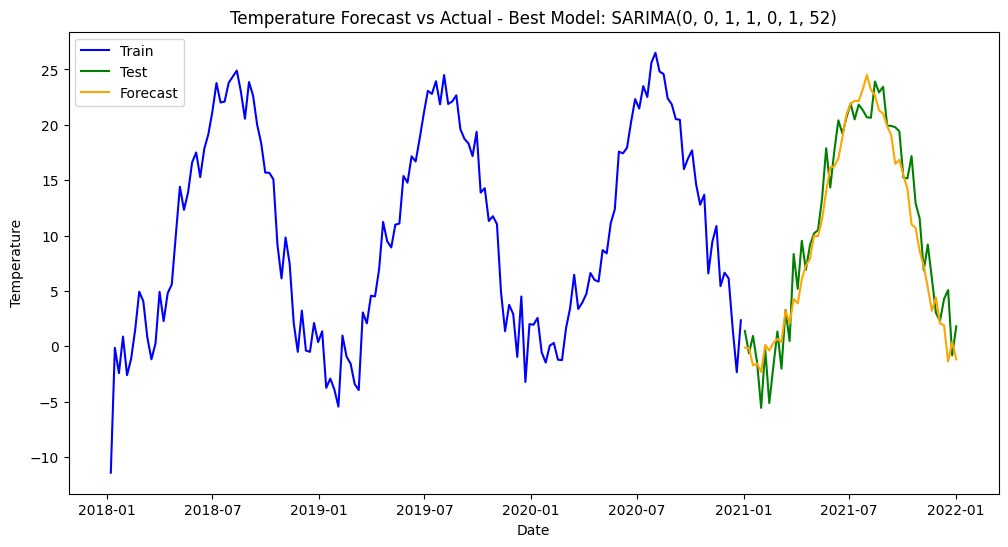

In [ ]:
# search for best SARIMA parameters

train_size = int(len(df_Boston[["Temperature"]]) * 0.75)
train, test = df_Boston[["Temperature"]][:train_size], df_Boston[["Temperature"]][train_size:]

p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 1)
Q_values = range(0, 3)
s_values = [52]

best_mse = float('inf')
best_params = None
best_model = None

for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    try:
        mse, results = fit_sarima_model(train, test, p, d, q, P, D, Q, s)
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q, P, D, Q, s)
            best_model = results
        print(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - MSE: {mse}')
    except Exception as e:
        print(f'Error fitting ARIMA({p},{d},{q})x({P},{D},{Q},{s}): {e}')

print(f'Best model: SARIMA{best_params} - MSE: {best_mse}')

test_forecast = best_model.get_forecast(steps=len(test)).predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, test_forecast, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title(f'Temperature Forecast vs Actual - Best Model: SARIMA{best_params}')
plt.legend()
plt.show()

## Relative Humidity

In [ ]:
# find ADF statistics and p values

result = adfuller(df_Boston["Relative Humidity"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

df_diff = df_Boston["Relative Humidity"].diff().dropna()

result_diff = adfuller(df_diff)
print(f'ADF Statistic (after differencing): {result_diff[0]}')
print(f'p-value (after differencing): {result_diff[1]}')

ADF Statistic: -4.443581014986723
p-value: 0.00024832958224376686
ADF Statistic (after differencing): -8.71221043632277
p-value (after differencing): 3.565916257850968e-14


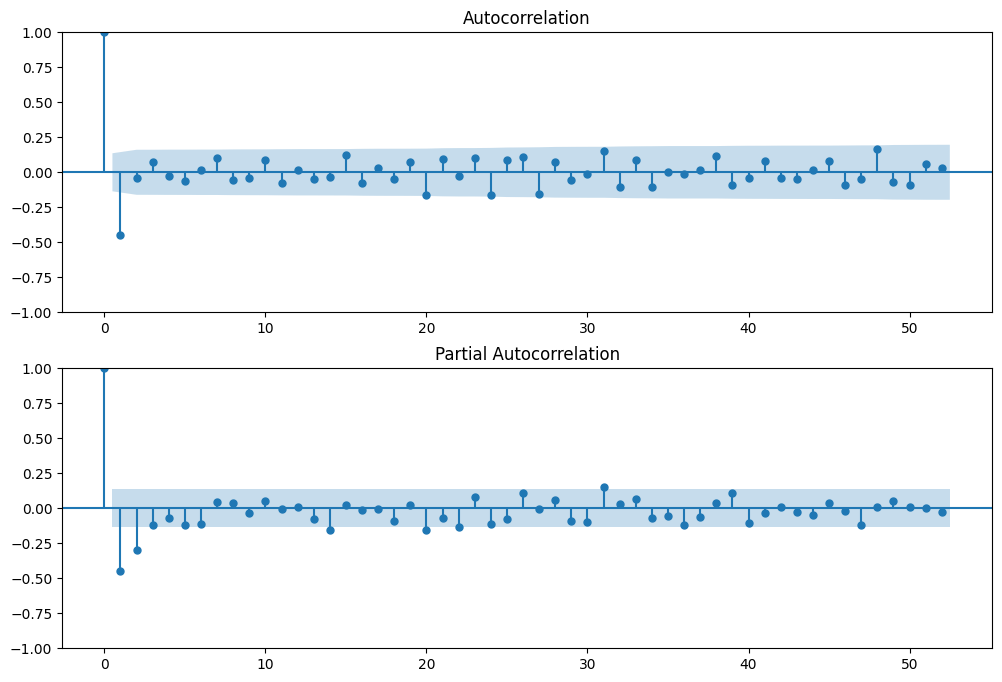

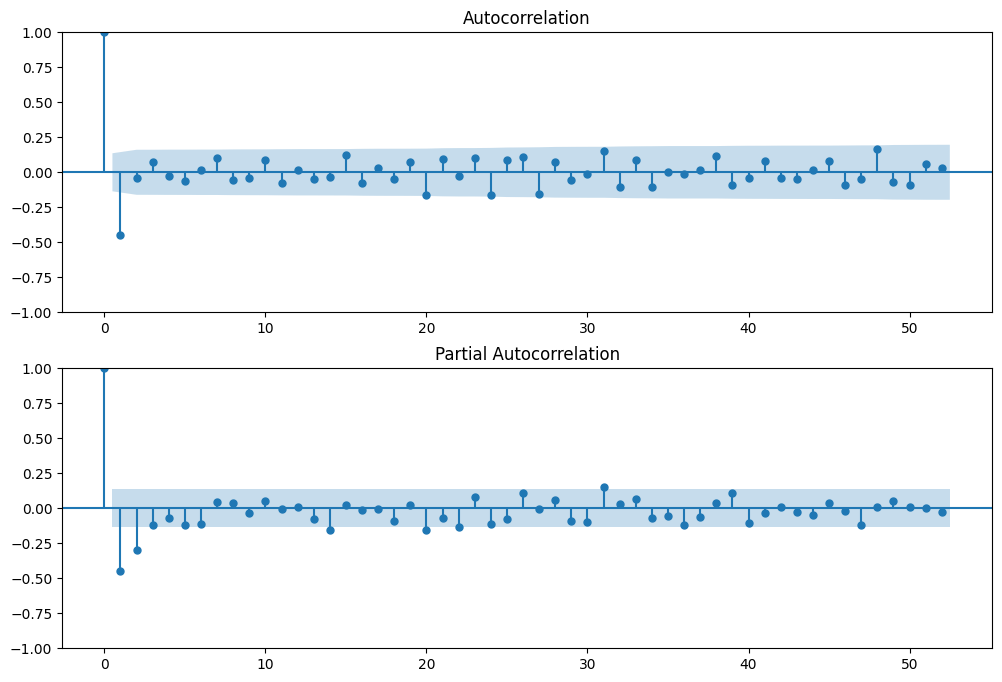

In [ ]:
# plot acf and pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=52, ax=ax[0])
plot_pacf(df_diff, lags=52, ax=ax[1])
# search for best SARIMA parametersplt.show()

SARIMA(0,0,0)x(0,0,0,52) - MSE: 6674.107932604569


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,1,52) - MSE: 1953.1660790785181


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,2,52) - MSE: 1330.6180012978057
SARIMA(0,0,0)x(1,0,0,52) - MSE: 83.42848816055111


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,1,52) - MSE: 81.33010148058551


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,2,52) - MSE: 90.16902113929393
SARIMA(0,0,0)x(2,0,0,52) - MSE: 81.45004251731666


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(2,0,1,52) - MSE: 82.49520894802092


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(2,0,2,52) - MSE: 92.55026498129519
SARIMA(0,0,1)x(0,0,0,52) - MSE: 6546.094675257671


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(0,0,1,52) - MSE: 1818.0533628339274


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(0,0,2,52) - MSE: 1708.9319428886736
SARIMA(0,0,1)x(1,0,0,52) - MSE: 84.68565650702769


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(1,0,1,52) - MSE: 76.6695775904566


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(1,0,2,52) - MSE: 1819.3488988064928
SARIMA(0,0,1)x(2,0,0,52) - MSE: 97.56574258699077


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(2,0,1,52) - MSE: 95.47289300537038


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(2,0,2,52) - MSE: 95.38558674511384
SARIMA(0,0,2)x(0,0,0,52) - MSE: 6598.960367817314


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(0,0,1,52) - MSE: 1938.8026912008015


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(0,0,2,52) - MSE: 1502.0485329254743
SARIMA(0,0,2)x(1,0,0,52) - MSE: 110.57512605492379


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(1,0,1,52) - MSE: 87.28240473540407


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(1,0,2,52) - MSE: 48.71433515162381
SARIMA(0,0,2)x(2,0,0,52) - MSE: 66.76235103890455


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(2,0,1,52) - MSE: 123.04368353620364


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(2,0,2,52) - MSE: 121.57912846429451
SARIMA(1,0,0)x(0,0,0,52) - MSE: 41.191197221317694


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,1,52) - MSE: 38.97135092361072


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,2,52) - MSE: 39.23413245236755
SARIMA(1,0,0)x(1,0,0,52) - MSE: 39.289320026381276


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(1,0,1,52) - MSE: 39.29007341281699


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(1,0,2,52) - MSE: 38.65584511477621
SARIMA(1,0,0)x(2,0,0,52) - MSE: 39.27853048205949


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(2,0,1,52) - MSE: 39.27210058756972


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,2,52) - MSE: 37.51146983868292
SARIMA(1,0,1)x(0,0,0,52) - MSE: 40.48046045606675


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,1,52) - MSE: 34.54282019322231


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,2,52) - MSE: 34.76996135432084
SARIMA(1,0,1)x(1,0,0,52) - MSE: 34.452060791908806


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(1,0,1,52) - MSE: 33.968071710289756


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(1,0,2,52) - MSE: 34.97005575904381
SARIMA(1,0,1)x(2,0,0,52) - MSE: 35.73326905250955


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(2,0,1,52) - MSE: 35.4262900018352


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(2,0,2,52) - MSE: 35.19504904673713


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


SARIMA(1,0,2)x(0,0,0,52) - MSE: 38.868995961361314


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,1,52) - MSE: 33.464559181708864


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,2,52) - MSE: 34.0723777332274


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


SARIMA(1,0,2)x(1,0,0,52) - MSE: 33.37653986451663


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(1,0,1,52) - MSE: 33.45479347853138


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(1,0,2,52) - MSE: 33.43251810957113


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


SARIMA(1,0,2)x(2,0,0,52) - MSE: 34.93766333906977


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(2,0,1,52) - MSE: 33.27798722555801


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,2,52) - MSE: 32.92645752847125
SARIMA(2,0,0)x(0,0,0,52) - MSE: 41.23043388299625


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,1,52) - MSE: 35.29801133290129


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,2,52) - MSE: 35.52335876600697
SARIMA(2,0,0)x(1,0,0,52) - MSE: 35.41615109737963


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(1,0,1,52) - MSE: 34.574141139926404


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(1,0,2,52) - MSE: 34.26655555911478
SARIMA(2,0,0)x(2,0,0,52) - MSE: 36.29946107184538


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(2,0,1,52) - MSE: 34.17989226723522


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(2,0,2,52) - MSE: 33.77153855963356


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


SARIMA(2,0,1)x(0,0,0,52) - MSE: 38.80648099355877


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,1,52) - MSE: 33.33641786167502


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,2,52) - MSE: 34.018705119308514


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


SARIMA(2,0,1)x(1,0,0,52) - MSE: 33.185267258483584


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(1,0,1,52) - MSE: 33.41427183800996


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(1,0,2,52) - MSE: 35.52129308800067


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


SARIMA(2,0,1)x(2,0,0,52) - MSE: 34.87581361620374


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(2,0,1,52) - MSE: 33.293885963308504


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(2,0,2,52) - MSE: 32.83125292082762


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,2)x(0,0,0,52) - MSE: 41.48224922195161


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(0,0,1,52) - MSE: 34.61685349403389


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(0,0,2,52) - MSE: 35.031613564385054


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,0,52) - MSE: 34.80067828741718


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,1,52) - MSE: 34.56084857257273


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,2,52) - MSE: 36.656041882235506


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,0,52) - MSE: 35.93618411969066


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,1,52) - MSE: 38.540105352877255


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,2,52) - MSE: 43.67654108558386
Best model: SARIMA(2, 0, 1, 2, 0, 2, 52) - MSE: 32.83125292082762


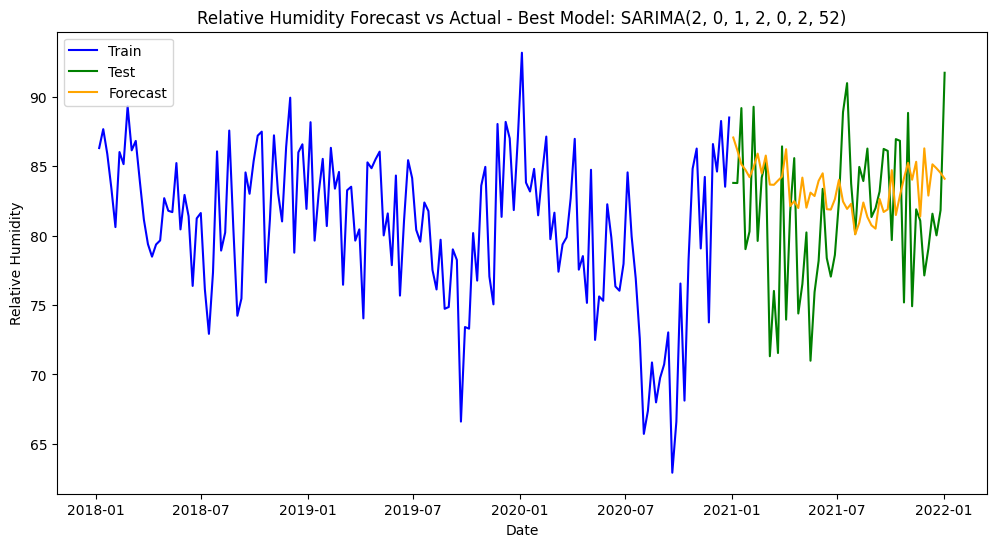

In [ ]:
# search for best SARIMA parameters

train_size = int(len(df_Boston[["Relative Humidity"]]) * 0.75)
train, test = df_Boston[["Relative Humidity"]][:train_size], df_Boston[["Relative Humidity"]][train_size:]

p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 1)
Q_values = range(0, 3)
s_values = [52]

best_mse = float('inf')
best_params = None
best_model = None

for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    try:
        mse, results = fit_sarima_model(train, test, p, d, q, P, D, Q, s)
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q, P, D, Q, s)
            best_model = results
        print(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - MSE: {mse}')
    except Exception as e:
        print(f'Error fitting ARIMA({p},{d},{q})x({P},{D},{Q},{s}): {e}')

print(f'Best model: SARIMA{best_params} - MSE: {best_mse}')

test_forecast = best_model.get_forecast(steps=len(test)).predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, test_forecast, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Relative Humidity')
plt.title(f'Relative Humidity Forecast vs Actual - Best Model: SARIMA{best_params}')
plt.legend()
plt.show()

## Pressure

In [ ]:
# find ADF statistics and p values

result = adfuller(df_Boston["Pressure"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

df_diff = df_Boston["Pressure"].diff().dropna()

result_diff = adfuller(df_diff)
print(f'ADF Statistic (after differencing): {result_diff[0]}')
print(f'p-value (after differencing): {result_diff[1]}')

ADF Statistic: -10.19744041205293
p-value: 6.093810090738369e-18
ADF Statistic (after differencing): -9.812490933676127
p-value (after differencing): 5.608780920644583e-17


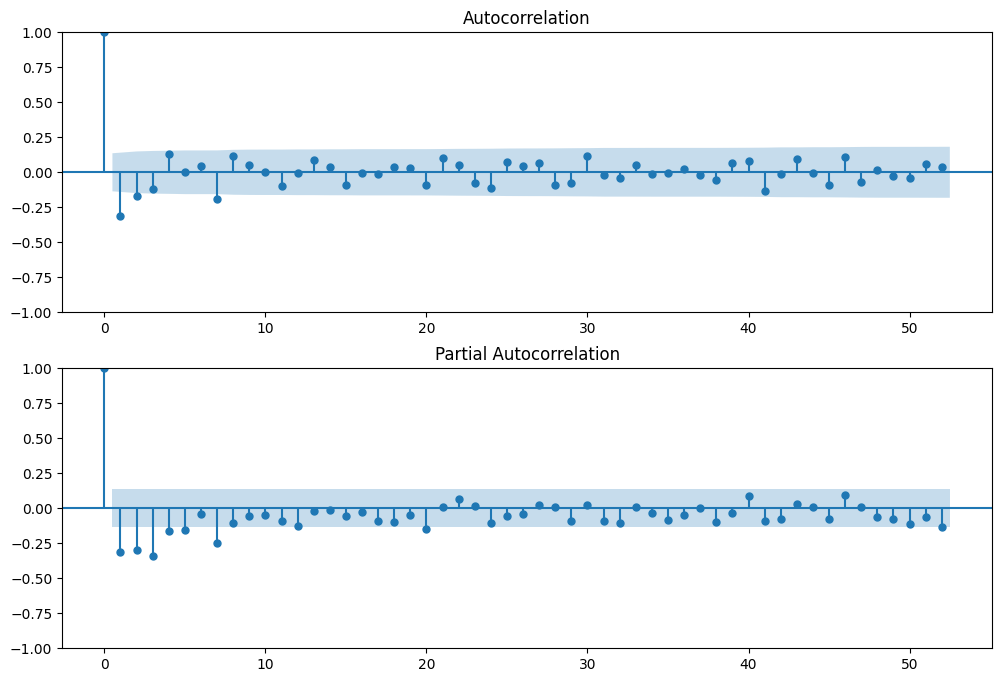

In [ ]:
# plot acf and pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=52, ax=ax[0])
plot_pacf(df_diff, lags=52, ax=ax[1])
plt.show()

SARIMA(0,0,0)x(0,0,0,52) - MSE: 1025376.2120064016


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(0,0,1,52) - MSE: 270457.3152012351


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,0)x(0,0,2,52) - MSE: 169967.60717270148
SARIMA(0,0,0)x(1,0,0,52) - MSE: 35.56172745673413


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,0)x(1,0,1,52) - MSE: 77.92103399267418


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,0)x(1,0,2,52) - MSE: 56.64738817553098
Error fitting ARIMA(0,0,0)x(2,0,0,52): LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,0)x(2,0,1,52) - MSE: 31.78279081942083


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,0)x(2,0,2,52) - MSE: 35.24322820831211


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(0,0,1)x(0,0,0,52) - MSE: 1010386.5229202781


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(0,0,1,52) - MSE: 260119.11921483796


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,1)x(0,0,2,52) - MSE: 157149.3717110812


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(0,0,1)x(1,0,0,52) - MSE: 40.210023043114205


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,1)x(1,0,1,52) - MSE: 76.13050073250044


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(1,0,2,52) - MSE: 260198.88867567256


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(0,0,1)x(2,0,0,52) - MSE: 61.36826178254094


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,1)x(2,0,1,52) - MSE: 61692311.15804791


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,1)x(2,0,2,52) - MSE: 75.80050642085996


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(0,0,2)x(0,0,0,52) - MSE: 995314.6740640508


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(0,0,1,52) - MSE: 253557.53437240928


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(0,0,2,52) - MSE: 142668.7408111009


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(0,0,2)x(1,0,0,52) - MSE: 35.27954184119542


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(1,0,1,52) - MSE: 75.14394342872032


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0,0,2)x(1,0,2,52) - MSE: 273401.20956010214


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(2,0,0,52) - MSE: 67.42731657203525


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0,0,2)x(2,0,1,52) - MSE: 47.63824696841085


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Error fitting ARIMA(0,0,2)x(2,0,2,52): LU decomposition error.
SARIMA(1,0,0)x(0,0,0,52) - MSE: 24.73737698346711


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,1,52) - MSE: 25.25841232382659


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(0,0,2,52) - MSE: 22.888891436796396


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(1,0,0,52) - MSE: 85.6351051282838


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(1,0,1,52) - MSE: 23.999170232474775


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,0)x(1,0,2,52) - MSE: 22.608941115561187


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,0,52) - MSE: 79.36655649838075


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,1,52) - MSE: 22.59783935479675


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,0)x(2,0,2,52) - MSE: 24.006783118680165
SARIMA(1,0,1)x(0,0,0,52) - MSE: 20.64626363116521


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,1,52) - MSE: 19.421887111640814


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(0,0,2,52) - MSE: 19.502473730084684


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(1,0,0,52) - MSE: 35.533277676812226


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,1)x(1,0,1,52) - MSE: 20.280634752339104


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(1,0,2,52) - MSE: 20.042483028926267
Error fitting ARIMA(1,0,1)x(2,0,0,52): LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(2,0,1,52) - MSE: 20.335430055585473


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,1)x(2,0,2,52) - MSE: 20.351651758551167
SARIMA(1,0,2)x(0,0,0,52) - MSE: 20.890897161837596


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,1,52) - MSE: 19.812353913978512


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,0,2)x(0,0,2,52) - MSE: 19.67906153274264
SARIMA(1,0,2)x(1,0,0,52) - MSE: 37.80998907899576


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(1,0,1,52) - MSE: 20.53831219128623


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(1,0,2,52) - MSE: 20.5060072683235


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,0,52) - MSE: 28.51931555179635


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,1,52) - MSE: 20.909734434079468


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1,0,2)x(2,0,2,52) - MSE: 20.55517042277184
SARIMA(2,0,0)x(0,0,0,52) - MSE: 20.287710671139305


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,1,52) - MSE: 20.060648032290814


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(0,0,2,52) - MSE: 20.17598888405578


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(1,0,0,52) - MSE: 64.80165195818103


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(1,0,1,52) - MSE: 20.027490364822796


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(1,0,2,52) - MSE: 20.056953357004094


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,0)x(2,0,0,52) - MSE: 49.470980588029484


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(2,0,1,52) - MSE: 20.205081324023165


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,0)x(2,0,2,52) - MSE: 20.23843661766403


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,1)x(0,0,0,52) - MSE: 25.083470437889236


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,1,52) - MSE: 25.550890860054135


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(0,0,2,52) - MSE: 23.154608501145788


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,1)x(1,0,0,52) - MSE: 44.73205235942159


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(1,0,1,52) - MSE: 25.102350185303294


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(1,0,2,52) - MSE: 27.53168539629813


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,1)x(2,0,0,52) - MSE: 23.345851869059448


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(2,0,1,52) - MSE: 25.091656425396828


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,1)x(2,0,2,52) - MSE: 22.825436350626696
SARIMA(2,0,2)x(0,0,0,52) - MSE: 20.78019695568331


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(0,0,1,52) - MSE: 19.093489174327473


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(0,0,2,52) - MSE: 19.411509969098283
SARIMA(2,0,2)x(1,0,0,52) - MSE: 38.1536096896554


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,1,52) - MSE: 20.683135295285805


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(1,0,2,52) - MSE: 20.17402359541693
SARIMA(2,0,2)x(2,0,0,52) - MSE: 28.795002618694387


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2,0,2)x(2,0,1,52) - MSE: 359.18119048543093


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,0,2)x(2,0,2,52) - MSE: 39.74487560424866
Best model: SARIMA(2, 0, 2, 0, 0, 1, 52) - MSE: 19.093489174327473


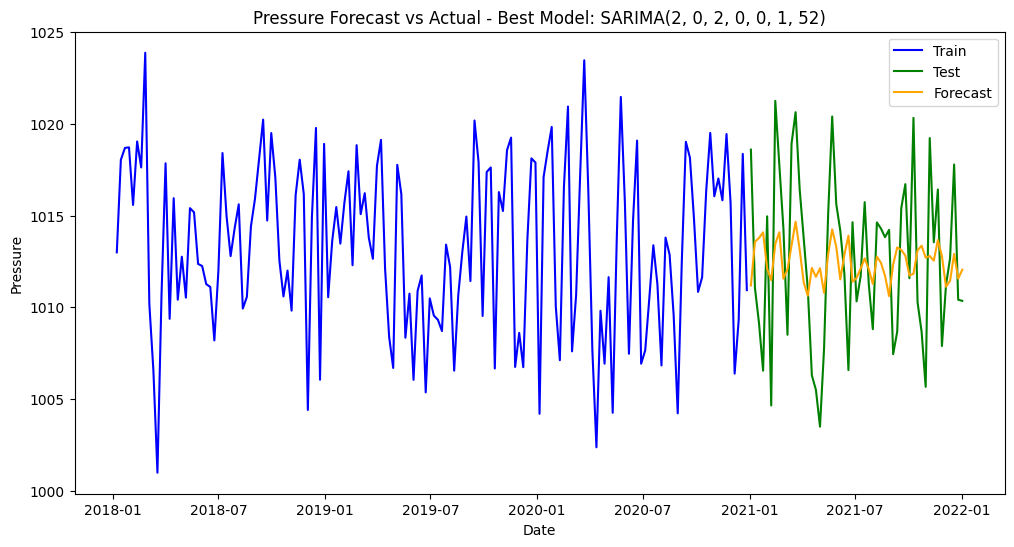

In [ ]:
# search for best SARIMA parameters

train_size = int(len(df_Boston[["Pressure"]]) * 0.75)
train, test = df_Boston[["Pressure"]][:train_size], df_Boston[["Pressure"]][train_size:]

p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 1)
Q_values = range(0, 3)
s_values = [52]

best_mse = float('inf')
best_params = None
best_model = None

for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    try:
        mse, results = fit_sarima_model(train, test, p, d, q, P, D, Q, s)
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q, P, D, Q, s)
            best_model = results
        print(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - MSE: {mse}')
    except Exception as e:
        print(f'Error fitting ARIMA({p},{d},{q})x({P},{D},{Q},{s}): {e}')

print(f'Best model: SARIMA{best_params} - MSE: {best_mse}')

test_forecast = best_model.get_forecast(steps=len(test)).predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, test_forecast, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Pressure')
plt.title(f'Pressure Forecast vs Actual - Best Model: SARIMA{best_params}')
plt.legend()
plt.show()

# Predictions

## Boston

### Wind Speed

In [ ]:
# Predict Wind Speed

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Boston["Wind Speed"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Boston_Wind_Speed = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Boston_Wind_Speed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09    1.130083
2022-01-16    1.123160
2022-01-23    1.361187
2022-01-30    1.301217
2022-02-06    1.404624
2022-02-13    1.260808
2022-02-20    1.319098
2022-02-27    1.391708
2022-03-06    1.632875
2022-03-13    1.300239
2022-03-20    1.239088
2022-03-27    0.953450
2022-04-03    1.163150
2022-04-10    0.837379
2022-04-17    0.927862
2022-04-24    0.828582
2022-05-01    0.754398
2022-05-08    0.647140
2022-05-15    0.575213
2022-05-22    0.550657
2022-05-29    0.723124
2022-06-05    0.487659
2022-06-12    0.518264
2022-06-19    0.498373
2022-06-26    0.498332
2022-07-03    0.581115
2022-07-10    0.502904
2022-07-17    0.492401
2022-07-24    0.481034
2022-07-31    0.536904
2022-08-07    0.498399
2022-08-14    0.478960
2022-08-21    0.552552
2022-08-28    0.563079
2022-09-04    0.640488
2022-09-11    0.644554
2022-09-18    0.667707
2022-09-25    0.647972
2022-10-02    0.692311
2022-10-09    0.811350
2022-10-16    0.754884
2022-10-23    0.752034
2022-10-30    1.061497
2022-11-06 

### GHI

In [ ]:
# Predict GHI

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Boston["GHI"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Boston_GHI = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Boston_GHI

2022-01-09     71.309119
2022-01-16     62.722036
2022-01-23     87.452336
2022-01-30     88.237116
2022-02-06     76.882937
2022-02-13     97.468698
2022-02-20    114.772665
2022-02-27    131.938661
2022-03-06    154.063031
2022-03-13    177.473270
2022-03-20    179.837674
2022-03-27    165.770317
2022-04-03    183.833805
2022-04-10    170.762606
2022-04-17    166.388736
2022-04-24    192.132444
2022-05-01    176.455779
2022-05-08    222.573665
2022-05-15    234.006764
2022-05-22    271.874219
2022-05-29    233.462839
2022-06-05    241.628542
2022-06-12    258.181023
2022-06-19    266.830292
2022-06-26    247.951272
2022-07-03    236.014398
2022-07-10    250.331534
2022-07-17    220.089455
2022-07-24    236.836249
2022-07-31    255.462362
2022-08-07    215.192919
2022-08-14    208.782560
2022-08-21    205.998777
2022-08-28    211.321192
2022-09-04    174.878997
2022-09-11    183.555575
2022-09-18    178.943775
2022-09-25    168.220223
2022-10-02    120.809490
2022-10-09    113.261687


### Temperature

In [ ]:
# Predict Temperature

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Boston["Temperature"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Boston_Temperature = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Boston_Temperature

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09     1.737034
2022-01-16    -1.010123
2022-01-23    -1.499569
2022-01-30    -3.404846
2022-02-06    -0.020492
2022-02-13    -1.733353
2022-02-20    -0.180287
2022-02-27     0.896506
2022-03-06    -0.455638
2022-03-13     3.044585
2022-03-20     1.508507
2022-03-27     5.525507
2022-04-03     4.221314
2022-04-10     7.058184
2022-04-17     7.239390
2022-04-24     8.401971
2022-05-01    10.224631
2022-05-08    10.269580
2022-05-15    12.169955
2022-05-22    15.351236
2022-05-29    15.655578
2022-06-05    16.672720
2022-06-12    18.053743
2022-06-19    19.024061
2022-06-26    20.913080
2022-07-03    22.061349
2022-07-10    21.715296
2022-07-17    22.140263
2022-07-24    22.660339
2022-07-31    23.397779
2022-08-07    22.488232
2022-08-14    23.065852
2022-08-21    21.830752
2022-08-28    21.858771
2022-09-04    20.020913
2022-09-11    19.362577
2022-09-18    17.593997
2022-09-25    17.659501
2022-10-02    15.368444
2022-10-09    14.542865
2022-10-16    12.791616
2022-10-23    11

### Relative Humidity

In [ ]:
# Predict Relative Humidity

p = 2
d = 0
q = 1
P = 2
D = 0
Q = 2
s = 52

model = SARIMAX(df_Boston["Relative Humidity"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Boston_Relative_Humidity = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Boston_Relative_Humidity

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2022-01-09    84.175050
2022-01-16    84.782751
2022-01-23    83.521612
2022-01-30    83.838230
2022-02-06    84.695441
2022-02-13    83.493472
2022-02-20    84.340512
2022-02-27    84.448613
2022-03-06    82.971950
2022-03-13    83.404160
2022-03-20    82.888027
2022-03-27    84.440736
2022-04-03    82.871601
2022-04-10    84.086545
2022-04-17    84.481944
2022-04-24    83.357627
2022-05-01    83.160858
2022-05-08    84.170349
2022-05-15    82.973730
2022-05-22    83.558548
2022-05-29    83.460459
2022-06-05    84.213250
2022-06-12    83.739281
2022-06-19    83.578508
2022-06-26    83.676618
2022-07-03    83.830419
2022-07-10    84.757413
2022-07-17    85.116706
2022-07-24    84.514832
2022-07-31    84.410943
2022-08-07    84.897250
2022-08-14    84.618490
2022-08-21    85.022969
2022-08-28    84.356362
2022-09-04    84.353204
2022-09-11    84.418501
2022-09-18    85.296563
2022-09-25    85.067486
2022-10-02    83.896273
2022-10-09    85.041877
2022-10-16    84.563442
2022-10-23    82

### Pressure

In [ ]:
# Predict Pressure

p = 2
d = 0
q = 2
P = 0
D = 0
Q = 1
s = 52

model = SARIMAX(df_Boston["Pressure"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Boston_Pressure = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Boston_Pressure

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09    1012.158700
2022-01-16    1011.721028
2022-01-23    1011.226571
2022-01-30    1013.101017
2022-02-06    1011.336971
2022-02-13    1014.021883
2022-02-20    1013.296391
2022-02-27    1013.064780
2022-03-06    1011.937266
2022-03-13    1013.591847
2022-03-20    1013.720603
2022-03-27    1013.167461
2022-04-03    1013.029321
2022-04-10    1012.607621
2022-04-17    1011.500773
2022-04-24    1011.397827
2022-05-01    1010.978134
2022-05-08    1011.963974
2022-05-15    1012.980203
2022-05-22    1013.690253
2022-05-29    1013.014521
2022-06-05    1013.017127
2022-06-12    1012.381965
2022-06-19    1011.175562
2022-06-26    1013.161028
2022-07-03    1012.280492
2022-07-10    1012.481565
2022-07-17    1013.088238
2022-07-24    1012.401206
2022-07-31    1012.047283
2022-08-07    1012.899037
2022-08-14    1012.853516
2022-08-21    1012.931694
2022-08-28    1013.159649
2022-09-04    1011.632978
2022-09-11    1011.648686
2022-09-18    1012.961471
2022-09-25    1013.218526
2022-10-02  

## Chicopee

### Wind Speed

In [ ]:
# Predict Wind Speed

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Chicopee["Wind Speed"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Chicopee_Wind_Speed = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Chicopee_Wind_Speed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


2022-01-09    0.321236
2022-01-16    0.331733
2022-01-23    0.456953
2022-01-30    0.437934
2022-02-06    0.492568
2022-02-13    0.483814
2022-02-20    0.462192
2022-02-27    0.514308
2022-03-06    0.537994
2022-03-13    0.462120
2022-03-20    0.359631
2022-03-27    0.285892
2022-04-03    0.263980
2022-04-10    0.180237
2022-04-17    0.116734
2022-04-24    0.055130
2022-05-01    0.034409
2022-05-08    0.011081
2022-05-15    0.028858
2022-05-22    0.030326
2022-05-29    0.009691
2022-06-05    0.019561
2022-06-12    0.024424
2022-06-19    0.037397
2022-06-26    0.036510
2022-07-03    0.028825
2022-07-10    0.048288
2022-07-17    0.024920
2022-07-24    0.041182
2022-07-31    0.036656
2022-08-07    0.046695
2022-08-14    0.035050
2022-08-21    0.030907
2022-08-28    0.025662
2022-09-04    0.028122
2022-09-11    0.024757
2022-09-18    0.041410
2022-09-25    0.056025
2022-10-02    0.032722
2022-10-09    0.065919
2022-10-16    0.092073
2022-10-23    0.040413
2022-10-30    0.052793
2022-11-06 

### GHI

In [ ]:
# Predict GHI

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Chicopee["GHI"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Chicopee_GHI = pd.Series(results.get_forecast(steps=52).predicted_mean)

### Temperature

In [ ]:
# Predict Temperature

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Chicopee["Temperature"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Chicopee_Temperature = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Chicopee_Temperature

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09     0.463384
2022-01-16    -2.742751
2022-01-23    -3.115930
2022-01-30    -5.180798
2022-02-06    -1.611812
2022-02-13    -3.133547
2022-02-20    -1.595626
2022-02-27     0.025465
2022-03-06    -1.414989
2022-03-13     2.491404
2022-03-20     1.064047
2022-03-27     5.541640
2022-04-03     3.981717
2022-04-10     7.812642
2022-04-17     7.316980
2022-04-24     8.696484
2022-05-01    11.558823
2022-05-08    11.216030
2022-05-15    12.706931
2022-05-22    16.903032
2022-05-29    17.162949
2022-06-05    17.436735
2022-06-12    19.037678
2022-06-19    20.097102
2022-06-26    21.934398
2022-07-03    23.223424
2022-07-10    23.313303
2022-07-17    23.535857
2022-07-24    23.122465
2022-07-31    23.540349
2022-08-07    22.560294
2022-08-14    23.938964
2022-08-21    22.017564
2022-08-28    22.146156
2022-09-04    19.911445
2022-09-11    19.537063
2022-09-18    17.791645
2022-09-25    17.323387
2022-10-02    15.304527
2022-10-09    14.463986
2022-10-16    11.886741
2022-10-23    10

### Relative Humidity

In [ ]:
# Predict Relative Humidity

p = 2
d = 0
q = 1
P = 2
D = 0
Q = 2
s = 52

model = SARIMAX(df_Chicopee["Relative Humidity"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Chicopee_Relative_Humidity = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Chicopee_Relative_Humidity

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2022-01-09    83.181948
2022-01-16    85.291237
2022-01-23    83.532644
2022-01-30    82.613696
2022-02-06    84.727988
2022-02-13    83.181139
2022-02-20    83.885577
2022-02-27    83.399716
2022-03-06    81.784701
2022-03-13    82.477183
2022-03-20    81.278313
2022-03-27    83.044312
2022-04-03    80.618111
2022-04-10    83.194000
2022-04-17    83.701815
2022-04-24    82.283214
2022-05-01    82.131716
2022-05-08    82.717111
2022-05-15    81.020938
2022-05-22    81.515397
2022-05-29    82.151313
2022-06-05    81.914028
2022-06-12    82.569609
2022-06-19    82.502355
2022-06-26    82.265283
2022-07-03    82.794793
2022-07-10    83.293284
2022-07-17    84.212674
2022-07-24    82.542731
2022-07-31    82.270874
2022-08-07    81.759671
2022-08-14    81.728712
2022-08-21    83.097897
2022-08-28    82.592449
2022-09-04    82.761746
2022-09-11    82.511251
2022-09-18    81.407259
2022-09-25    82.026688
2022-10-02    80.691821
2022-10-09    82.613425
2022-10-16    82.581124
2022-10-23    81

### Pressure

In [ ]:
# Predict Pressure
#(2, 0, 2, 0, 0, 1, 52)

p = 2
d = 0
q = 2
P = 0
D = 0
Q = 1
s = 52

model = SARIMAX(df_Chicopee["Pressure"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Chicopee_Pressure = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Chicopee_Pressure

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09    1004.184412
2022-01-16    1003.369914
2022-01-23    1003.354202
2022-01-30    1004.678882
2022-02-06    1003.283740
2022-02-13    1005.446800
2022-02-20    1005.076628
2022-02-27    1004.595846
2022-03-06    1003.973013
2022-03-13    1005.217199
2022-03-20    1005.511933
2022-03-27    1004.676668
2022-04-03    1004.940343
2022-04-10    1004.240018
2022-04-17    1003.459629
2022-04-24    1003.273397
2022-05-01    1003.159306
2022-05-08    1003.618776
2022-05-15    1004.981640
2022-05-22    1005.414434
2022-05-29    1004.880978
2022-06-05    1004.745654
2022-06-12    1004.361741
2022-06-19    1003.119108
2022-06-26    1005.041513
2022-07-03    1004.090643
2022-07-10    1004.418440
2022-07-17    1004.702519
2022-07-24    1004.395405
2022-07-31    1003.861559
2022-08-07    1004.866438
2022-08-14    1004.600165
2022-08-21    1004.760702
2022-08-28    1004.779856
2022-09-04    1003.768365
2022-09-11    1003.534426
2022-09-18    1004.843552
2022-09-25    1004.777232
2022-10-02  

### Sturbridge

## Wind Speed

In [ ]:
# Predict Wind Speed

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Sturbridge["Wind Speed"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Sturbridge_Wind_Speed = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Sturbridge_Wind_Speed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09    0.276455
2022-01-16    0.285606
2022-01-23    0.395390
2022-01-30    0.384420
2022-02-06    0.438336
2022-02-13    0.443360
2022-02-20    0.428712
2022-02-27    0.486899
2022-03-06    0.505710
2022-03-13    0.440345
2022-03-20    0.347700
2022-03-27    0.275331
2022-04-03    0.257666
2022-04-10    0.180775
2022-04-17    0.128951
2022-04-24    0.047108
2022-05-01    0.019123
2022-05-08    0.011442
2022-05-15    0.023780
2022-05-22    0.018104
2022-05-29    0.011771
2022-06-05    0.012936
2022-06-12    0.021214
2022-06-19    0.029613
2022-06-26    0.030543
2022-07-03    0.022139
2022-07-10    0.031889
2022-07-17    0.019506
2022-07-24    0.033877
2022-07-31    0.027240
2022-08-07    0.030270
2022-08-14    0.023387
2022-08-21    0.027028
2022-08-28    0.020161
2022-09-04    0.020239
2022-09-11    0.019248
2022-09-18    0.032824
2022-09-25    0.036611
2022-10-02    0.026089
2022-10-09    0.045015
2022-10-16    0.079507
2022-10-23    0.037641
2022-10-30    0.047866
2022-11-06 

### GHI

In [ ]:
# Predict GHI

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Sturbridge["GHI"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Sturbridge_GHI = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Sturbridge_GHI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09     80.897615
2022-01-16     60.336231
2022-01-23     86.886011
2022-01-30     90.934566
2022-02-06     79.040957
2022-02-13    101.382879
2022-02-20    121.992929
2022-02-27    126.539965
2022-03-06    168.469954
2022-03-13    184.597940
2022-03-20    181.174042
2022-03-27    164.443629
2022-04-03    176.203107
2022-04-10    192.737866
2022-04-17    155.237865
2022-04-24    196.252754
2022-05-01    178.925191
2022-05-08    201.696733
2022-05-15    237.354844
2022-05-22    277.932575
2022-05-29    228.300954
2022-06-05    239.120158
2022-06-12    261.666023
2022-06-19    274.832927
2022-06-26    255.701688
2022-07-03    237.004191
2022-07-10    235.973822
2022-07-17    215.171002
2022-07-24    237.776713
2022-07-31    254.071860
2022-08-07    221.858058
2022-08-14    216.256598
2022-08-21    203.014810
2022-08-28    202.231352
2022-09-04    183.878399
2022-09-11    182.584723
2022-09-18    188.148683
2022-09-25    164.894814
2022-10-02    128.353189
2022-10-09    108.513933


### Temperature

In [ ]:
# Predict Temperature

p = 0
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 52

model = SARIMAX(df_Sturbridge["Temperature"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Sturbridge_Temperature = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Sturbridge_Temperature

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09    -0.255887
2022-01-16    -3.213369
2022-01-23    -3.535949
2022-01-30    -5.779342
2022-02-06    -2.050401
2022-02-13    -3.611248
2022-02-20    -2.051923
2022-02-27    -0.638890
2022-03-06    -2.183397
2022-03-13     1.720942
2022-03-20     0.179625
2022-03-27     4.675366
2022-04-03     3.044043
2022-04-10     6.685006
2022-04-17     6.377245
2022-04-24     7.731609
2022-05-01    10.282010
2022-05-08    10.169747
2022-05-15    11.703470
2022-05-22    15.595847
2022-05-29    15.924586
2022-06-05    16.381750
2022-06-12    17.965326
2022-06-19    18.884155
2022-06-26    20.794690
2022-07-03    21.918535
2022-07-10    21.913082
2022-07-17    22.267770
2022-07-24    22.095003
2022-07-31    22.623925
2022-08-07    21.703954
2022-08-14    22.836185
2022-08-21    21.081435
2022-08-28    21.233496
2022-09-04    19.075929
2022-09-11    18.604483
2022-09-18    16.796903
2022-09-25    16.477723
2022-10-02    14.446710
2022-10-09    13.482541
2022-10-16    11.229344
2022-10-23     9

### Relative Humidity

In [ ]:
# Predict Relative Humidity

p = 2
d = 0
q = 1
P = 2
D = 0
Q = 2
s = 52

model = SARIMAX(df_Sturbridge["Relative Humidity"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Sturbridge_Relative_Humidity = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Sturbridge_Relative_Humidity

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2022-01-09    87.675612
2022-01-16    88.520216
2022-01-23    87.306555
2022-01-30    88.056586
2022-02-06    87.811698
2022-02-13    87.038478
2022-02-20    86.231431
2022-02-27    87.953239
2022-03-06    84.646439
2022-03-13    85.826349
2022-03-20    86.025835
2022-03-27    88.316782
2022-04-03    87.560597
2022-04-10    87.215075
2022-04-17    88.076557
2022-04-24    86.363234
2022-05-01    86.321743
2022-05-08    87.568655
2022-05-15    85.305481
2022-05-22    87.275933
2022-05-29    86.899997
2022-06-05    88.809314
2022-06-12    88.137944
2022-06-19    86.905095
2022-06-26    87.301712
2022-07-03    89.373473
2022-07-10    90.966845
2022-07-17    89.801719
2022-07-24    86.566306
2022-07-31    87.444753
2022-08-07    87.935125
2022-08-14    86.312591
2022-08-21    88.778630
2022-08-28    89.500701
2022-09-04    88.805970
2022-09-11    86.845733
2022-09-18    88.789803
2022-09-25    87.208681
2022-10-02    86.294384
2022-10-09    87.121272
2022-10-16    89.195625
2022-10-23    85

### Pressure

In [ ]:
# Predict Pressure
# modified parameters due to invalid output from original parameters

p = 1
d = 0
q = 1
P = 0
D = 0
Q = 1
s = 52

model = SARIMAX(df_Sturbridge["Pressure"], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)
forecast_Sturbridge_Pressure = pd.Series(results.get_forecast(steps=52).predicted_mean)
forecast_Sturbridge_Pressure

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2022-01-09    989.643223
2022-01-16    989.206396
2022-01-23    988.838953
2022-01-30    990.528523
2022-02-06    988.776116
2022-02-13    991.349923
2022-02-20    990.637478
2022-02-27    990.502872
2022-03-06    989.479849
2022-03-13    991.081128
2022-03-20    991.083030
2022-03-27    990.565102
2022-04-03    990.502126
2022-04-10    990.069122
2022-04-17    988.962825
2022-04-24    989.061453
2022-05-01    988.640277
2022-05-08    989.431693
2022-05-15    990.503442
2022-05-22    991.240802
2022-05-29    990.439498
2022-06-05    990.582481
2022-06-12    989.920747
2022-06-19    988.872247
2022-06-26    990.648701
2022-07-03    989.903479
2022-07-10    989.989550
2022-07-17    990.549048
2022-07-24    989.943851
2022-07-31    989.656164
2022-08-07    990.424976
2022-08-14    990.418994
2022-08-21    990.360450
2022-08-28    990.633352
2022-09-04    989.281309
2022-09-11    989.313643
2022-09-18    990.436520
2022-09-25    990.638455
2022-10-02    990.057893
2022-10-09    991.395051


# Determining Potential Energy Using Predicted Variables

## Functions

In [ ]:
# set available land considering possible land and portion allocated to solar
def setAs(potential_land, solar_allocation):
  A_s = potential_land * solar_allocation
  return A_s

# find potential solar energy for the year
def solar_potential(A_s, forecast_GHI, n, L):
  # iterate through each week's potential energy for year and sum
  energy = sum(A_s * (i * 24 * 7) * n * (1 - L) for i in forecast_GHI)
  # convert to kW
  P_s = energy / 1000
  return P_s

# set available land considering possible land and portion allocated to solar
def setAw(potential_land, wind_allocation):
  A_w = potential_land * wind_allocation
  return A_w

# determine predicted weekly air densities
def air_density(forecast_temperature, forecast_relative_humidity, forecast_pressure):
  air_density = pd.Series(index=forecast_temperature.index)

  for i in forecast_temperature.index:
    temperature = forecast_temperature.loc[i]
    relative_humidity = forecast_relative_humidity.loc[i]
    pressure = forecast_pressure.loc[i]

    # convert Celsius to Kelvin
    T = temperature + 273.15
    # convert mbar to PA
    p = pressure * 100

    # calculate vapor pressure
    e_s = 6.112 * np.exp(17.67 * temperature / (temperature + 243.5)) * 100
    vp = relative_humidity * e_s / 100

    # calculate dry air pressure
    dp = p - vp

    # gas constants
    Rd = 287.05
    Rv = 461.5

    # calculate air density
    ad = (dp / (Rd * T)) + (vp / (Rv * T))
    air_density.loc[i] = ad

  return air_density

# find potential wind energy for the year
def wind_potential(A_w, air_density, forecast_wind_speed, radius, C, n):
    # determine how many turbines can fit in available area
    n_turbines = A_w / math.floor(21 * (2 * radius)**2)
    # calculate energy per week
    energy = 0.5 * air_density * (np.pi*(radius**2)) * (forecast_wind_speed)**3 * 24 * 7 * C * n
    # sum energy for year
    total_energy = energy.sum()
    # convert to kW
    P_w = (total_energy / 1000) * n_turbines
    return P_w

# find potential hydro energy for the year
def hydro_potential(city, cf):
  # create dataset for only city
  df_city = df_NHA[df_NHA['City'] == city]

  # create dataset with only Hydro dams
  df_preexisting_dams = df_city[df_city['Hydro?'] == 'Y']
  # create dataset with all dams
  df_dams = df_city

  # determine total energy being produced per year if preexisting dams run 12 hours per day
  min_P_h = (df_preexisting_dams['Capacity'].sum() * 4320 * cf) * 1000
  min_n_h = df_preexisting_dams.shape[0]

  # determine total energy being produced per year if all dams run 12 hours per day
  P_h = (df_dams['Capacity'].sum() * 4320 * cf) * 1000
  n_h = df_dams.shape[0]

  print(f"Minimum energy from hydro: {int(min_P_h)} kW, {int(min_n_h)} dam(s)")
  print(f"Maximum energy from hydro: {int(P_h)} kW, {int(n_h)} dam(s)")
  return P_h, n_h, min_P_h, min_n_h

Boston Potential

In [ ]:
# Solar

# Considerations:
# 882578.88 m^2 available land in Boston; considering an allocation of .1 for solar; .8 and .2 general estimates for n and L

#set A_s
A_s = setAs(882578.88, .05)

# determine solar power potential for Boston
P_s_Boston = solar_potential(A_s, forecast_Boston_GHI, .8, .2)

# Potential Solar Energy for Boston for the year
print(P_s_Boston)

38846071.81873006


In [ ]:
# Wind

A_w = setAw(882578.88, .5)

air_density_series = air_density(forecast_Boston_Temperature, forecast_Boston_Relative_Humidity, forecast_Boston_Pressure)

P_w_Boston = wind_potential(A_w, air_density_series, forecast_Boston_Wind_Speed, 10, 1, .8)

# Potential Wind Energy for Boston for the year
print(P_w_Boston)

64178.75697151316


In [ ]:
# Hydro

P_h_Boston, n_h_Boston, min_P_h_Boston, min_n_h_Boston = hydro_potential('Boston', .4)

Minimum energy from hydro: 0 kW, 0 dam(s)
Maximum energy from hydro: 0 kW, 0 dam(s)


## Chicopee Potential

In [ ]:
# total size of Chicopee: 61.9 mil m^2
# percentage public land in MA 6.3%
# 6.3% of 61.9 mil
# 3.89 mil m^2

# Solar

#set A_s
A_s = setAs(3899700, .07)

# determine solar power potential for Boston
P_s_Chicopee = solar_potential(A_s, forecast_Chicopee_GHI, .8, .4)

# Potential Solar Energy for Chicop
print(P_s_Chicopee)

180130409.67278963


In [ ]:
A_w = setAw(3899700, .5)

air_density_series = air_density(forecast_Chicopee_Temperature, forecast_Chicopee_Relative_Humidity, forecast_Chicopee_Pressure)

P_w_Chicopee = wind_potential(A_w, air_density_series, forecast_Chicopee_Wind_Speed, 15, 1, .8)

print(P_w_Chicopee)

6891.745175034628


In [ ]:
# Hydro

P_h_Chicopee, n_h_Chicopee, min_P_h_Chicopee, min_n_h_Chicopee = hydro_potential('Chicopee', .4)

Minimum energy from hydro: 6220799 kW, 2 dam(s)
Maximum energy from hydro: 6220799 kW, 2 dam(s)


## Sturbridge Potential

In [ ]:
# total size of Chicopee: 100.9 mil m^2
# percentage public land in MA 6.3%
# 6.3% of 100.9 mil
# 6.3567 mil m^2

# Solar

#set A_s
A_s = setAs(6356700, .1)

# determine solar power potential for Boston
P_s_Sturbridge = solar_potential(A_s, forecast_Sturbridge_GHI, .8, .2)

print(P_s_Sturbridge)

565311593.5332952


In [ ]:
A_w = setAw(6356700, .45)

air_density_series = air_density(forecast_Sturbridge_Temperature, forecast_Sturbridge_Relative_Humidity, forecast_Sturbridge_Pressure)

P_w_Sturbridge = wind_potential(A_w, air_density_series, forecast_Sturbridge_Wind_Speed, 25, 1, .8)

print(P_w_Sturbridge)

7738.425611384431


In [ ]:
P_h_Sturbridge, n_h_Sturbridge, min_P_h_Sturbridge, min_n_h_Sturbridge = hydro_potential('Sturbridge', .4)

Minimum energy from hydro: 117504 kW, 1 dam(s)
Maximum energy from hydro: 1890699 kW, 2 dam(s)


# Determine Optimal Cost

In [ ]:
def find_cheapest_combination(solar_production, wind_production, total_hydro, hydro_installed, hydro_production, hydro_produced, demand):
    # Define the costs of each energy source

    C_s = 3.51  # Solar installation cost ($/watt)
    C_w = 1750  # Wind installation cost ($/kW)
    C_h = 2000000  # Hydro installation cost (assumption)

    solar_cost = 3.51 * solar_production * 1000
    wind_cost = 1750 * wind_production
    hydro_cost =  (total_hydro - hydro_installed) * 2000000

    # Energy demand
    D = demand  # kWh/year

    # Find the cheapest combination
    min_cost = float('inf')
    cheapest_combination = None

    # Check all possible combinations
    for solar in [True, False]:
        for wind in [True, False]:
            for hydro in [True, False]:
                #if not (solar or wind or hydro):
                    #continue
                if (solar and solar_production == 0) or (wind and wind_production == 0) or (hydro and (hydro_production - hydro_produced) == 0):
                    continue

                total_energy = (solar * solar_production) + (wind * wind_production) + (hydro * (hydro_production - hydro_produced))
                total_cost = (solar * solar_cost) + (wind * wind_cost) + (hydro * hydro_cost)

                # If total energy exceeds demand, set it to demand and adjust cost
                if total_energy >= D:
                  ratio = (D / total_energy)
                  total_energy = D
                  total_cost = (total_cost * ratio)

                # Check if the combination meets the demand and is cheaper than the current minimum cost
                if total_energy == D and total_cost < min_cost:
                  min_cost = total_cost
                  cheapest_combination = (solar, wind, hydro)

    if cheapest_combination is None:
        return None, None, None

    energy = 0
    list_cheapest = []
    if cheapest_combination[0]:
        list_cheapest.append('Solar')
        energy = energy + solar_production
    if cheapest_combination[1]:
        list_cheapest.append('Wind')
        energy = energy + wind_production
    if cheapest_combination[2]:
        list_cheapest.append('Hydro')
        energy = energy + (hydro_production - hydro_produced)

    energy = min(energy, D)

    return min_cost, list_cheapest, energy

In [ ]:
min_cost_Boston, cheapest_combo_Boston, energy_Boston = find_cheapest_combination(P_s_Boston, P_w_Boston, n_h_Boston, min_n_h_Boston, P_h_Boston, min_P_h_Boston, 2000000)
print(f"Cheapest combination: {cheapest_combo_Boston}")
print(f"Minimum cost: ${min_cost_Boston}")
print(f"Energy produced: {energy_Boston}")

Cheapest combination: ['Solar', 'Wind']
Minimum cost: $7014194094.841403
Energy produced: 2000000


In [ ]:
min_cost_Chicopee, cheapest_combo_Chicopee, energy_Chicopee = find_cheapest_combination(P_s_Chicopee, P_w_Chicopee, n_h_Chicopee, min_n_h_Chicopee, P_h_Chicopee, min_P_h_Chicopee, 1000000)
print(f"Cheapest combination: {cheapest_combo_Chicopee}")
print(f"Minimum cost: ${min_cost_Chicopee}")
print(f"Energy produced: {energy_Chicopee}")

Cheapest combination: ['Solar', 'Wind']
Minimum cost: $3509932665.4090376
Energy produced: 1000000


In [ ]:
min_cost_Sturbridge, cheapest_combo_Sturbridge, energy_Sturbridge = find_cheapest_combination(P_s_Sturbridge, P_w_Sturbridge, n_h_Sturbridge, min_n_h_Sturbridge, P_h_Sturbridge, min_P_h_Sturbridge, 1000000)
print(f"Cheapest combination: {cheapest_combo_Sturbridge}")
print(f"Minimum cost: ${min_cost_Sturbridge}")
print(f"Energy produced: {energy_Sturbridge}")

Cheapest combination: ['Hydro']
Minimum cost: $1127906.9998269337
Energy produced: 1000000
